# 1. Reading Data, Exploring and Preprocessing

In [1]:
import numpy as np
import pandas as pd

In [2]:
def reading_and_preprocessing(filepath):
    df = pd.read_csv(filepath, encoding="latin1")
    lst_of_cols = list(df.columns)
    df["CreationDate"] = df["CreationDate"].apply(lambda x: pd.to_datetime(x))
    if("Title" in lst_of_cols): df["Title"] = df["Title"].apply(lambda x: str(x))
    df["Body"] = df["Body"].apply(lambda x: str(x))
    df.set_index("Id", inplace=True)
    return df[(df["CreationDate"] > "2008-10-14 23:59:59") & (df["CreationDate"] < "2016-10-13 00:00:00")]  

In [3]:
%store -r python_questions
%store -r python_answers
%store -r python_tags
%store -r python_tags_new
%store -r stack_questions
%store -r stack_answers
%store -r stack_tags
%store -r stack_tags_new

In [4]:
# python_questions = reading_and_preprocessing("./pythonquestions/Questions.csv")
# python_answers = reading_and_preprocessing("./pythonquestions/Answers.csv")
# python_tags = pd.read_csv("./pythonquestions/Tags.csv")
# stack_questions = reading_and_preprocessing("./stacksample/Questions.csv")
# stack_answers = reading_and_preprocessing("./stacksample/Answers.csv")
# stack_tags = pd.read_csv("./stacksample/Tags.csv")

In [5]:
print("Python Answers: " + str(python_answers.shape))
print("Python Questions: " + str(python_questions.shape))
print("Python Tags: " + str(python_tags.shape))
print("Python Tags (Aggregated): " + str(python_tags_new.shape))
print("StackOverflow Sample Answers: " + str(stack_answers.shape))
print("StackOverflow Sample Questions: " + str(stack_questions.shape))
print("StackOverflow Sample Tags: " + str(stack_tags.shape))
print("StackOverflow Tags (Aggregated): " + str(stack_tags_new.shape))

Python Answers: (979544, 5)
Python Questions: (602869, 5)
Python Tags: (1885078, 2)
Python Tags (Aggregated): (607283, 2)
StackOverflow Sample Answers: (1997427, 5)
StackOverflow Sample Questions: (1255956, 6)
StackOverflow Sample Tags: (3750994, 2)
StackOverflow Tags (Aggregated): (1264216, 2)


## 1.1. Python Dataset

In [6]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
%matplotlib inline
sns.set_palette("Set3", n_colors=20, desat=.8)

In [7]:
def count_line_of_code(text):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        bs = BeautifulSoup(text)
        if(bs.pre is None): return 0
        count = str(bs.pre).count("\n")
        if count == 0: return 1
        else: return count

def extra_cleaning(text):
    new_text = re.sub("(&lt;)+|(&gt;)+|(i\.e\.)+|(e\.g\.)+", "", text)
    return new_text

def get_word_count_from_df(df):
    qns_word = df["Body Word Count"].value_counts()
    qns_word.index = df["Body Word Count"].value_counts().index.astype(str)
    qns_word = pd.DataFrame(qns_word).reset_index()
    qns_word.columns = ["Word Count", "Occurences"]
    qns_word["Word Count"] = qns_word["Word Count"].apply(lambda x: x + "w")
    qns_word.set_index("Word Count", inplace=True)
    return qns_word

def plot_score_title_body_length(df):
    questions_title_length = df["Title"].apply(lambda x: len(x))
    questions_body_length = df["Body"].apply(lambda x: len(x))
    fig, ax = plt.subplots(ncols=3, nrows=1)
    fig.set_size_inches(11.7, 4)
    sns.distplot(df[(df.Score <= 50) & (df.Score >= -20)].Score, ax=ax[0], color="#074484", kde=False)
    sns.distplot(questions_title_length, ax=ax[1], color="#074484", kde=False)
    sns.distplot(questions_body_length[questions_body_length < 10000], ax=ax[2], color="#074484", kde=False)

def return_code_body(text):
    pattern = re.compile(r'<[^>]+>|\n|\r')
    soup = BeautifulSoup(text, 'html.parser')
    return pattern.sub(" ", str(soup.pre))

def return_code_df(df):
    return pd.DataFrame(df["Body"].apply(lambda x: return_code_body(x)).apply(lambda y: extra_cleaning(y)))

def return_word_count(text):
    return len(list(filter(lambda x: x not in string.punctuation, re.findall("(\S+)", text))))

def sampling_clean_text(df, num_of_samples = None):   
    if(num_of_samples != None): test_code = df.sample(n=num_of_samples)
    else: test_code = df.copy()
    test_code["Code Body"] = test_code["Body"].apply(lambda x: return_code_body(x)).apply(lambda y: extra_cleaning(y))
    test_code["Body Exc. Code"] = test_code["Body"].str.replace(r'<pre>([a]|[^a])+</pre>'," ").str.replace(r"<[^>]+>|\n|\r", " ").str.replace(r"(http\S+)|(www\.\S+)|(\S+\.com)", " ")
    test_code["Body Exc. Code"] = test_code["Body Exc. Code"].apply(lambda x: extra_cleaning(x))
    if("Title" in list(test_code.columns)): 
        test_code["Text for Analysis (Title + Body Exc. Code)"] = test_code["Title"].str.cat(test_code["Body Exc. Code"], sep = " ")
        test_code["Full Body (Title + Body + Code)"] = test_code["Text for Analysis (Title + Body Exc. Code)"].str.cat(test_code["Code Body"], sep = " ")
    return test_code.reindex_axis(sorted(test_code.columns), axis=1)

In [8]:
%store -r python_questions_cleaned
%store -r python_answers_cleaned

In [9]:
python_questions.head(3)

,OwnerUserId,CreationDate,Score,Title,Body
Id,,,,,
203487,5646.0,2008-10-15 02:00:27,19,Creating self-contained python applications,<p>I'm trying to create a self-contained versi...
203758,115.0,2008-10-15 04:55:33,2,Receive socket size limits good?,<p>I am writing a program in Python that will ...
203859,432.0,2008-10-15 06:22:22,2,"How do I get python-markdown to additionally ""...",<p>Markdown is a great tool for formatting pla...


In [10]:
# python_questions_cleaned = sampling_clean_text(python_questions)
# python_questions_body_word_count = python_questions_cleaned["Body Exc. Code"].apply(return_word_count)
# python_questions_cleaned["Body Word Count"] = python_questions_body_word_count
# python_questions_lines_of_code = python_questions_cleaned["Body"].apply(lambda x: count_line_of_code(x))
# python_questions_cleaned["Lines of Code"] = python_questions_lines_of_code
python_questions_cleaned.head()

,Body,Body Exc. Code,CreationDate,OwnerUserId,Score,Text for Analysis (Title + Body Exc. Code),Title,Body Word Count,Lines of Code
Id,,,,,,,,,
203487,<p>I'm trying to create a self-contained versi...,I'm trying to create a self-contained version...,2008-10-15 02:00:27,5646.0,19,Creating self-contained python applications I...,Creating self-contained python applications,78,0
203758,<p>I am writing a program in Python that will ...,I am writing a program in Python that will ac...,2008-10-15 04:55:33,115.0,2,Receive socket size limits good? I am writing...,Receive socket size limits good?,78,0
203859,<p>Markdown is a great tool for formatting pla...,Markdown is a great tool for formatting plain...,2008-10-15 06:22:22,432.0,2,"How do I get python-markdown to additionally ""...","How do I get python-markdown to additionally ""...",41,0
203912,<p>What is the difference between multiprocess...,What is the difference between multiprocessor...,2008-10-15 06:59:50,20211.0,60,Does python support multiprocessor/multicore p...,Does python support multiprocessor/multicore p...,26,0
204017,<p>I have a python script that needs to execut...,I have a python script that needs to execute ...,2008-10-15 08:24:28,267.0,206,How do I execute a program from python? os.sys...,How do I execute a program from python? os.sys...,23,3


In [11]:
python_answers.head(3)

,OwnerUserId,CreationDate,ParentId,Score,Body
Id,,,,,
203332,8247.0,2008-10-15 00:31:10,202939,1,"<p>You should also take a look at <a href=""htt..."
203514,3119.0,2008-10-15 02:17:35,203487,20,"<p>Check out <a href=""http://www.pyinstaller.o..."
203679,18676.0,2008-10-15 03:54:29,202939,1,"<p>You might want to look at <a href=""http://k..."


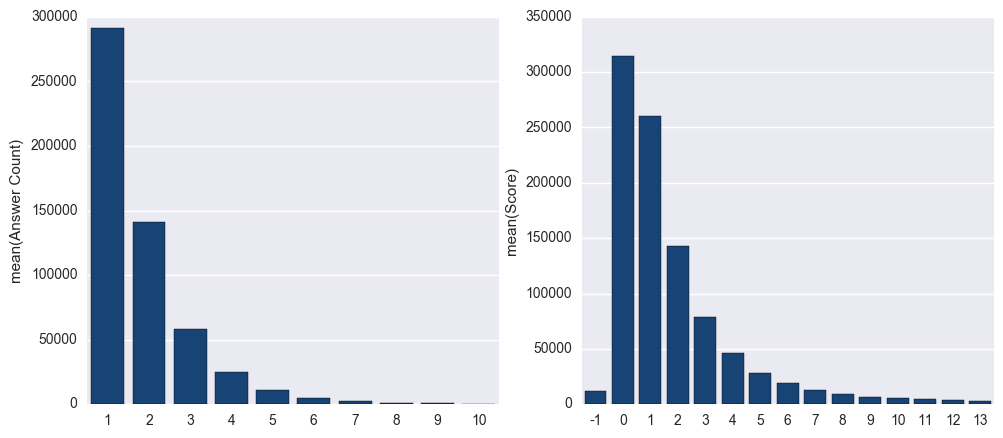

In [12]:
answer_count = pd.DataFrame(python_answers.groupby("ParentId").count()["Body"])
answer_count.columns = ["Answer Count"]
answer_count_larger = answer_count[(answer_count["Answer Count"] >= 1) & (answer_count["Answer Count"] <= 10)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=answer_count_larger["Answer Count"].value_counts(), x=answer_count_larger["Answer Count"].value_counts().index, 
            color="#074484", ax=ax[0])
sns.barplot(y=python_answers["Score"].value_counts()[:15], x=python_answers["Score"].value_counts()[:15].index, 
            color="#074484", ax=ax[1])

In [13]:
# python_answers_cleaned = sampling_clean_text(python_answers)
# python_answers_body_word_count = python_answers_cleaned["Body Exc. Code"].apply(return_word_count)
# python_answers_cleaned["Body Word Count"] = python_answers_body_word_count
# python_answers_lines_of_code = python_answers_cleaned["Body"].apply(count_line_of_code)
# python_answers_cleaned["Lines of Code"] = python_answers_lines_of_code
python_answers_cleaned.head(3)

,Body,Body Exc. Code,CreationDate,OwnerUserId,ParentId,Score,Body Word Count,Lines of Code
Id,,,,,,,,
203332,"<p>You should also take a look at <a href=""htt...",You should also take a look at web2py which...,2008-10-15 00:31:10,8247.0,202939,1,22,0
203514,"<p>Check out <a href=""http://www.pyinstaller.o...","Check out pyinstaller , it makes standalone ...",2008-10-15 02:17:35,3119.0,203487,20,15,0
203679,"<p>You might want to look at <a href=""http://k...",You might want to look at Karrigell . It has...,2008-10-15 03:54:29,18676.0,202939,1,49,0


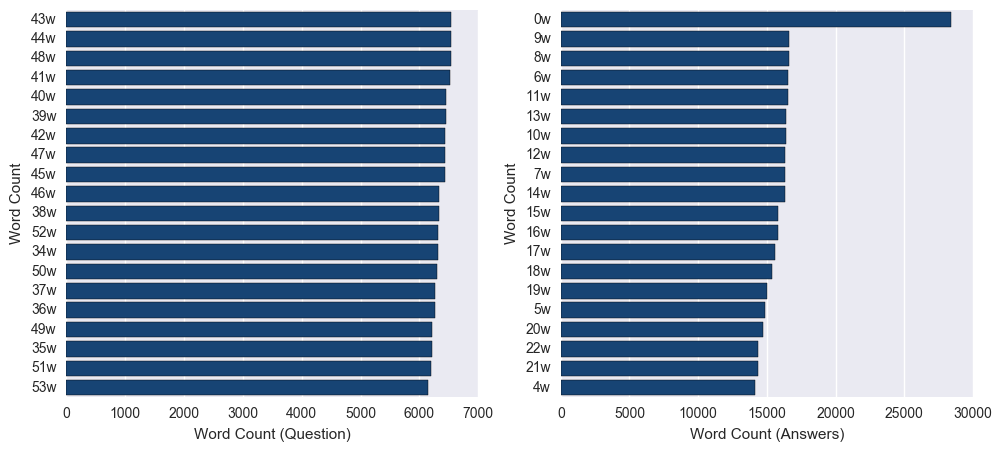

In [14]:
qns_word = get_word_count_from_df(python_questions_cleaned)
ans_word = get_word_count_from_df(python_answers_cleaned)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(x=qns_word.Occurences[:20], y=qns_word.index[:20], 
            color="#074484", ax=ax[0])
ax[0].set_xlabel("Word Count (Question)")
sns.barplot(x=ans_word.Occurences[:20], y=ans_word.index[:20], 
            color="#074484", ax=ax[1])
ax[1].set_xlabel("Word Count (Answers)")

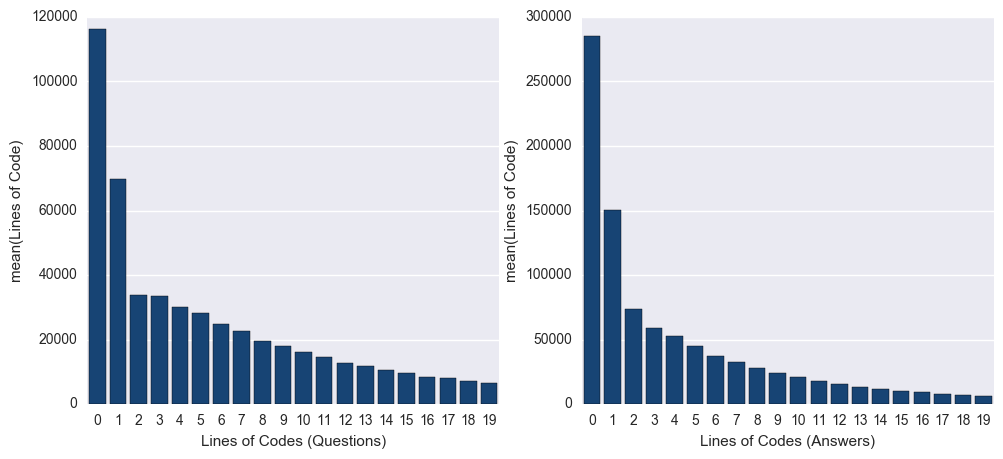

In [15]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=python_questions_cleaned["Lines of Code"].value_counts()[:20], x=python_questions_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#074484", ax=ax[0], orient="v")
ax[0].set_xlabel("Lines of Codes (Questions)")
sns.barplot(y=python_answers_cleaned["Lines of Code"].value_counts()[:20], x=python_answers_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#074484", ax=ax[1], orient="v")
ax[1].set_xlabel("Lines of Codes (Answers)")

In [16]:
python_tags.head(3)

,Id,Tag
0,469,python
1,469,osx
2,469,fonts


In [17]:
# python_tags["Tag"] = python_tags["Tag"].astype(str)
# python_tags_new = python_tags.groupby("Id").agg({"Tag": ["count", lambda x: ", ". join(x)]})
# python_tags_new.columns = python_tags_new.columns.get_level_values(0)
# python_tags_new.columns = ["Tag Count", "Tags"]
python_tags_new.head(3)

,Tag Count,Tags
Id,,
469,4,"python, osx, fonts, photoshop"
502,4,"python, windows, image, pdf"
535,3,"python, continuous-integration, extreme-progra..."


In [18]:
python_tags_count = pd.DataFrame(python_tags_new["Tag Count"].value_counts()).rename_axis("Tag Count").rename_axis({"Tag Count": "Occurences"}, axis="columns")
python_tags_count.head()

,Occurences
Tag Count,
3,189589
2,155095
4,133714
5,85595
1,43290


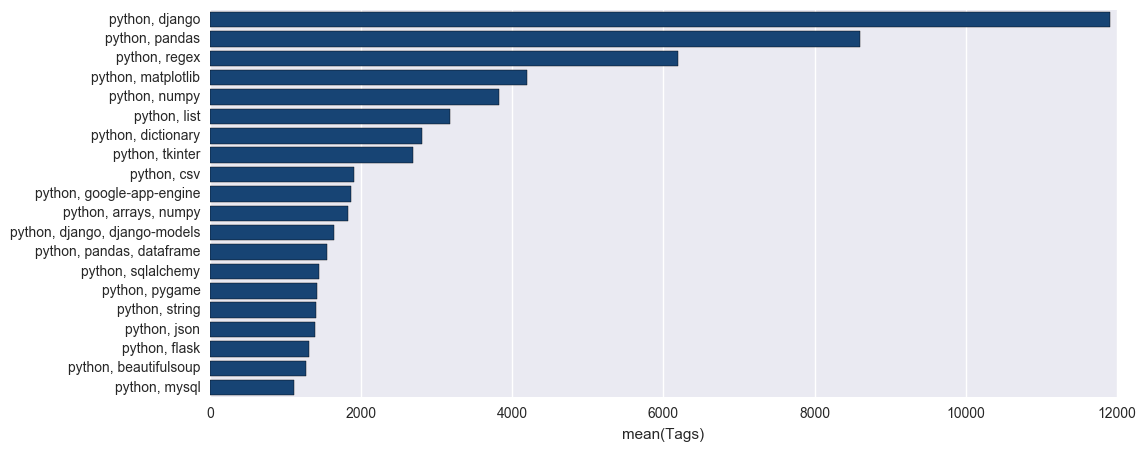

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(x=python_tags_new.loc[python_tags_new["Tags"].apply(lambda x: (", "in x) & (x.count("python") < 2)), "Tags"].value_counts()[:20], 
            y=python_tags_new.loc[python_tags_new["Tags"].apply(lambda x: (", "in x) & (x.count("python") < 2)), "Tags"].value_counts()[:20].index, 
            color="#074484", orient="horizontal")

In [20]:
def find_top_n_import(df, n, ax = None, color = "#074484"):
    pattern = re.compile(r'(from\s([^\s]+)\simport\s([^\s]+)|import\s([^\s]+))')
    sample_text_import = df["Code Body"].str.extractall(pattern)[0]
    sample_text_import_count = sample_text_import.value_counts()
    sample_text_import_count_df = pd.DataFrame(sample_text_import_count, index=sample_text_import_count.index, columns=["Count"])
    if(ax == None): return sns.barplot(y=sample_text_import_count_df.iloc[0:n].index,
            x=sample_text_import_count_df.iloc[0:n].Count, 
            data=sample_text_import_count_df.iloc[0:n],
            color=color)
    else: return sns.barplot(y=sample_text_import_count_df.iloc[0:n].index,
            x=sample_text_import_count_df.iloc[0:n].Count, 
            data=sample_text_import_count_df.iloc[0:n],
            color=color, ax = ax)

In [21]:
%store -r python_code_questions_df
%store -r python_code_answer_df

In [22]:
# python_code_answer_df = return_code_df(python_answers_cleaned).rename_axis({"Body": "Code Body"}, axis="columns")
# python_code_questions_df = return_code_df(python_questions_cleaned).rename_axis({"Body": "Code Body"}, axis="columns")

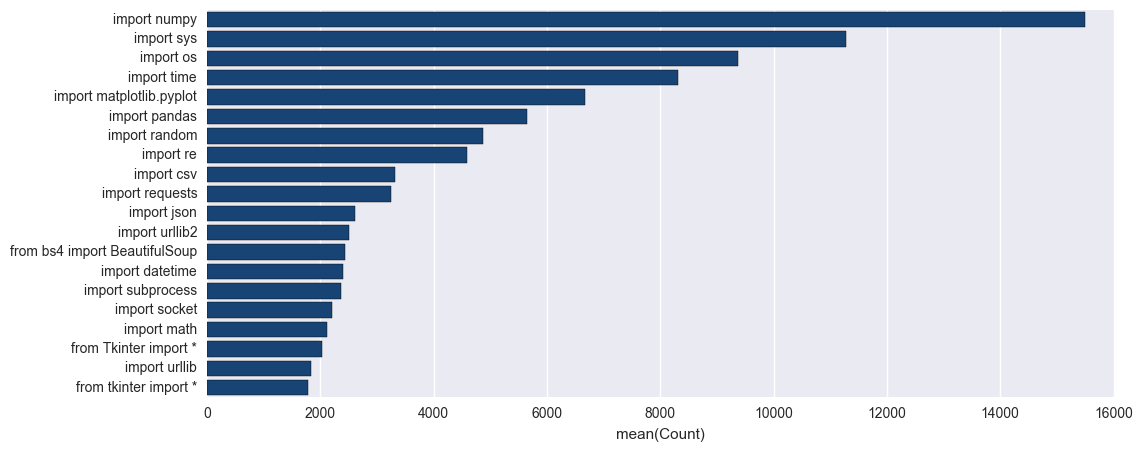

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
find_top_n_import(python_code_questions_df, 20)

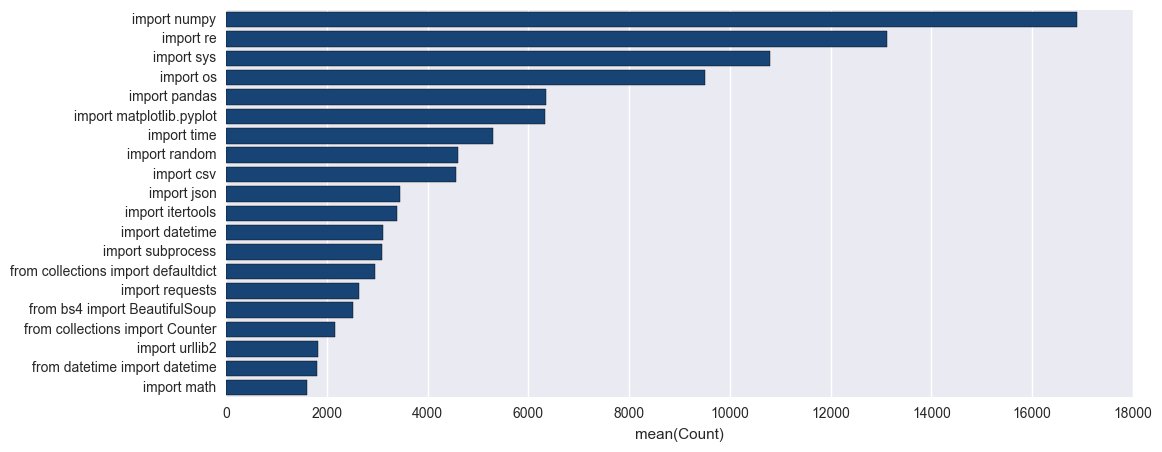

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
find_top_n_import(python_code_answer_df, 20)

## 1.2. StackOverflow 10% Sample Dataset

In [25]:
%store -r stack_answers_cleaned
%store -r stack_questions_cleaned

In [26]:
stack_questions.head(3)

,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
Id,,,,,,
203340,27580.0,2008-10-15 00:35:54,NaN,32,"JQuery: Current, Well-Formatted, Printable Doc...","<p>I'm looking for a current (1.2), well-forma..."
203520,5496.0,2008-10-15 02:19:28,NaN,2,How do I discriminate between data binding and...,<p>I have what must be a typical catch-22 prob...
203590,361.0,2008-10-15 03:05:53,NaN,0,Include directory in VS 2003,<p>Where is the setting in Visual Studio 2003 ...


In [27]:
# stack_questions_cleaned = sampling_clean_text(stack_questions)
# stack_questions_body_word_count = stack_questions_cleaned["Body Exc. Code"].apply(return_word_count)
# stack_questions_cleaned["Body Word Count"] = stack_questions_body_word_count
# stack_questions_lines_of_code = stack_questions_cleaned["Body"].apply(lambda x: count_line_of_code(x))
# stack_questions_cleaned["Lines of Code"] = stack_questions_lines_of_code
# stack_questions_cleaned.drop("ClosedDate", inplace=True, axis=1)
# stack_questions_cleaned.drop("Body", inplace=True, axis=1)
# stack_questions_cleaned.drop("Full Body (Title + Body + Code)", inplace=True, axis=1)
stack_questions_cleaned.head()

,Body Exc. Code,Code Body,CreationDate,OwnerUserId,Score,Text for Analysis (Title + Body Exc. Code),Title,Body Word Count,Lines of Code
Id,,,,,,,,,
203340,"I'm looking for a current (1.2), well-formatt...",None,2008-10-15 00:35:54,27580.0,32,"JQuery: Current, Well-Formatted, Printable Doc...","JQuery: Current, Well-Formatted, Printable Doc...",185,0
203520,I have what must be a typical catch-22 proble...,None,2008-10-15 02:19:28,5496.0,2,How do I discriminate between data binding and...,How do I discriminate between data binding and...,325,0
203590,Where is the setting in Visual Studio 2003 to...,None,2008-10-15 03:05:53,361.0,0,Include directory in VS 2003 Where is the set...,Include directory in VS 2003,41,0
203620,I need ideas on how to go about table layout ...,None,2008-10-15 03:25:18,28098.0,2,How to make a bilingual site without creating ...,How to make a bilingual site without creating ...,25,0
203640,"url is "" But it renders as: "" "" ...","a xsl:attribute name=""href"" xsl:value-of s...",2008-10-15 03:35:44,NaN,1,Why do my XSL transformed links come out relat...,Why do my XSL transformed links come out relat...,8,7


In [28]:
stack_answers.head(3)

,OwnerUserId,CreationDate,ParentId,Score,Body
Id,,,,,
203282,25688.0,2008-10-15 00:04:23,202750,5,"<p><a href=""http://en.wikipedia.org/wiki/Hyper..."
203290,18255.0,2008-10-15 00:08:28,203040,2,"<p>Firstly, it's probably not SQL Server throw..."
203326,21239.0,2008-10-15 00:29:06,202750,17,"<p><a href=""http://www.dangermouse.net/esoteri..."


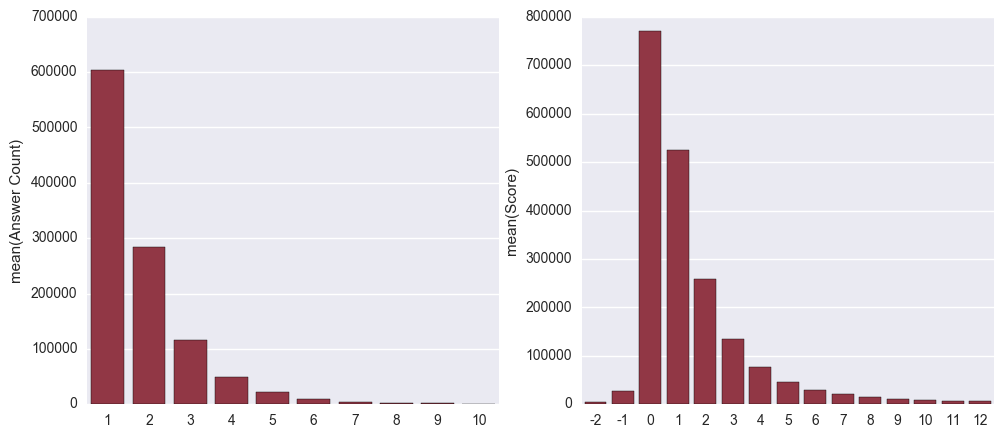

In [29]:
stack_answer_count = pd.DataFrame(stack_answers.groupby("ParentId").count()["Body"])
stack_answer_count.columns = ["Answer Count"]
stack_answer_count_larger = stack_answer_count[(stack_answer_count["Answer Count"] >= 1) & (stack_answer_count["Answer Count"] <= 10)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=stack_answer_count_larger["Answer Count"].value_counts(), x=stack_answer_count_larger["Answer Count"].value_counts().index, 
            color="#A0283A", ax=ax[0])
sns.barplot(y=stack_answers["Score"].value_counts()[:15], x=stack_answers["Score"].value_counts()[:15].index, 
            color="#A0283A", ax=ax[1])

In [30]:
# stack_answers_cleaned = sampling_clean_text(stack_answers)
# stack_answers_body_word_count = stack_answers_cleaned["Body Exc. Code"].apply(return_word_count)
# stack_answers_cleaned["Body Word Count"] = stack_answers_body_word_count
# stack_answers_lines_of_code = stack_answers_cleaned["Body"].apply(lambda x: count_line_of_code(x))
# stack_answers_cleaned["Lines of Code"] = stack_answers_lines_of_code
# stack_answers_cleaned.drop("Body", inplace=True, axis=1)
stack_answers_cleaned.head(3)

,Body Exc. Code,Code Body,CreationDate,OwnerUserId,ParentId,Score,Body Word Count,Lines of Code
Id,,,,,,,,
203282,HyperTalk and its descendant AppleScript ...,None,2008-10-15 00:04:23,25688.0,202750,5,14,0
203290,"Firstly, it's probably not SQL Server throwin...",None,2008-10-15 00:08:28,18255.0,203040,2,175,0
203326,Chef ! Anyone can read recipes right? Behold...,Ingredients. 72 g haricot beans 101 eggs 108...,2008-10-15 00:29:06,21239.0,202750,17,22,18


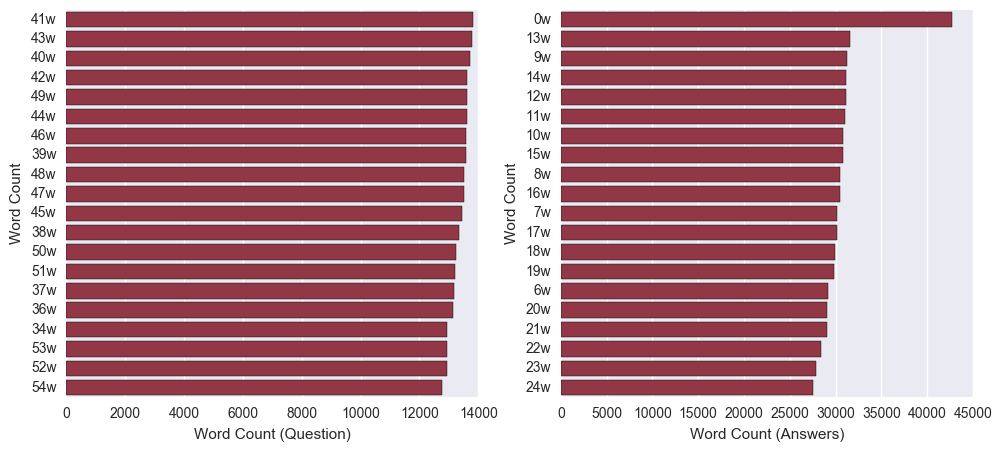

In [31]:
stack_qns_word = get_word_count_from_df(stack_questions_cleaned)
stack_ans_word = get_word_count_from_df(stack_answers_cleaned)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(x=stack_qns_word.Occurences[:20], y=stack_qns_word.index[:20], 
            color="#A0283A", ax=ax[0])
ax[0].set_xlabel("Word Count (Question)")
sns.barplot(x=stack_ans_word.Occurences[:20], y=stack_ans_word.index[:20], 
            color="#A0283A", ax=ax[1])
ax[1].set_xlabel("Word Count (Answers)")

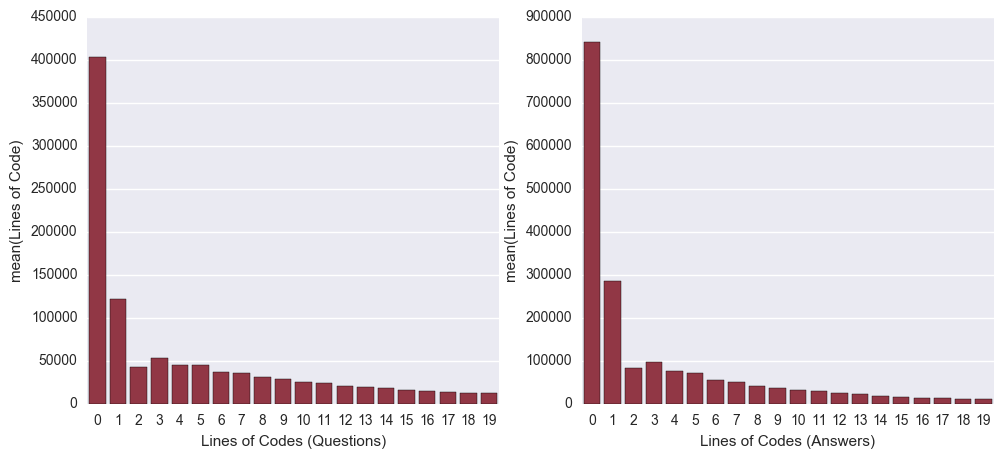

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=stack_questions_cleaned["Lines of Code"].value_counts()[:20], x=stack_questions_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#A0283A", ax=ax[0], orient="v")
ax[0].set_xlabel("Lines of Codes (Questions)")
sns.barplot(y=stack_answers_cleaned["Lines of Code"].value_counts()[:20], x=stack_answers_cleaned["Lines of Code"].value_counts()[:20].index, 
            color="#A0283A", ax=ax[1], orient="v")
ax[1].set_xlabel("Lines of Codes (Answers)")

In [33]:
stack_tags.head(3)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air


In [34]:
# stack_tags["Tag"] = stack_tags["Tag"].astype(str)
# stack_tags_new = stack_tags.groupby("Id").agg({"Tag": ["count", lambda x: ", ". join(x)]})
# stack_tags_new.columns = stack_tags_new.columns.get_level_values(0)
# stack_tags_new.columns = ["Tag Count", "Tags"]
stack_tags_new.head(3)

,Tag Count,Tags
Id,,
80,3,"flex, actionscript-3, air"
90,4,"svn, tortoisesvn, branch, branching-and-merging"
120,3,"sql, asp.net, sitemap"


In [35]:
stack_tags_count = pd.DataFrame(stack_tags_new["Tag Count"].value_counts()).rename_axis("Tag Count").rename_axis({"Tag Count": "Occurences"}, axis="columns")
stack_tags_count.head()

,Occurences
Tag Count,
3,367669
2,326804
4,254224
5,165491
1,150028


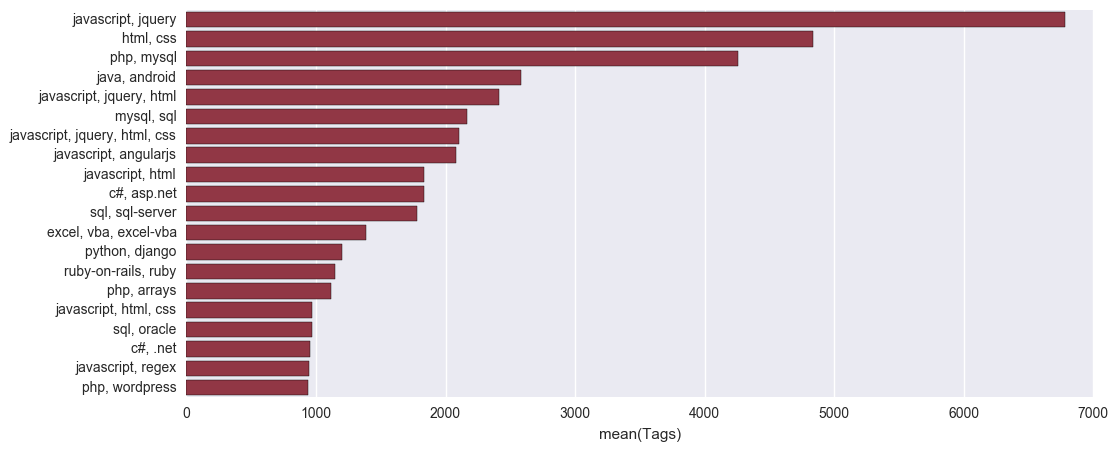

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(x=stack_tags_new.loc[stack_tags_new["Tags"].apply(lambda x: (", "in x)), "Tags"].value_counts()[:20], 
            y=stack_tags_new.loc[stack_tags_new["Tags"].apply(lambda x: (", "in x)), "Tags"].value_counts()[:20].index, 
            color="#A0283A", orient="horizontal")

#  

# 2. Constructing Tokenizer and Traditional Clustering

In [37]:
import spacy
import string
from sklearn.preprocessing import normalize

In [38]:
stop_words = ['a', 'able', 'about', 'above', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 
              'actually', 'added', 'adj', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'again', 
              'against', 'ah', 'all', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 
              'among', 'amongst', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 
              'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apparently', 'approximately', 'are', 'aren', 
              'arent', 'arise', 'around', 'as', 'aside', 'ask', 'asking', 'at', 'auth', 'available', 'away', 'awfully', 
              'b', 'back', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 
              'begin', 'beginning', 'beginnings', 'begins', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 
              'between', 'beyond', 'biol', 'both', 'brief', 'briefly', 'but', 'by', 'c', 'ca', 'came', 'can', 'cannot', 
              "can't", 'cause', 'causes', 'certain', 'certainly', 'co', 'com', 'come', 'comes', 'contain', 'containing', 
              'contains', 'could', 'couldnt', 'd', 'date', 'did', "didn't", 'different', 'do', 'does', "doesn't", 'doing', 
              'done', "don't", 'down', 'downwards', 'due', 'during', 'e', 'each', 'ed', 'edu', 'effect', 'eg', 'eight', 
              'eighty', 'either', 'else', 'elsewhere', 'end', 'ending', 'enough', 'especially', 'et', 'et - al', 'etc', 
              'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'except', 'f', 'far', 
              'few', 'ff', 'fifth', 'first', 'five', 'fix', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 
              'forth', 'found', 'four', 'from', 'further', 'furthermore', 'g', 'gave', 'get', 'gets', 'getting', 'give', 
              'given', 'gives', 'giving', 'go', 'goes', 'gone', 'got', 'gotten', 'h', 'had', 'happens', 'hardly', 'has', 
              "hasn't", 'have', "haven't", 'having', 'he', 'hed', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 
              'heres', 'hereupon', 'hers', 'herself', 'hes', 'hi', 'hid', 'him', 'himself', 'his', 'hither', 'home', 'how', 
              'howbeit', 'however', 'hundred', 'i', 'id', 'ie', 'if', "i'll", 'im', 'immediate', 'immediately', 'importance', 
              'important', 'in', 'inc', 'indeed', 'index', 'information', 'instead', 'into', 'invention', 'inward', 'is', 
              "isn't", 'it', 'itd', "it'll", 'its', 'itself', "i've", 'j', 'just', 'k', 'keep\tkeeps', 'kept', 'kg', 'km', 
              'know', 'known', 'knows', 'l', 'largely', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 
              'lest', 'let', 'lets', 'like', 'liked', 'likely', 'line', 'little', "'ll", 'look', 'looking', 'looks', 'ltd', 
              'm', 'made', 'mainly', 'make', 'makes', 'many', 'may', 'maybe', 'me', 'mean', 'means', 'meantime', 'meanwhile', 
              'merely', 'mg', 'might', 'million', 'miss', 'ml', 'more', 'moreover', 'most', 'mostly', 'mr', 'mrs', 'much', 'mug', 
              'must', 'my', 'myself', 'n', 'na', 'name', 'namely', 'nay', 'nd', 'near', 'nearly', 'necessarily', 'necessary', 
              'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nine', 'ninety', 'no', 'nobody', 'non', 
              'none', 'nonetheless', 'noone', 'nor', 'normally', 'nos', 'not', 'noted', 'nothing', 'now', 'nowhere', 'o', 
              'obtain', 'obtained', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'omitted', 'on', 'once', 
              'one', 'ones', 'only', 'onto', 'oop', 'oops', 'or', 'ord', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 
              'out', 'outside', 'over', 'overall', 'owing', 'own', 'p', 'page', 'pages', 'part', 'particular', 'particularly', 
              'past', 'per', 'perhaps', 'placed', 'please', 'plus', 'poorly', 'possible', 'possibly', 'potentially', 'pp', 
              'predominantly', 'present', 'previously', 'primarily', 'probably', 'promptly', 'proud', 'provides', 'put', 'q', 
              'que', 'quickly', 'quite', 'qv', 'r', 'ran', 'rather', 'rd', 're', 'readily', 'really', 'recent', 'recently', 
              'ref', 'refs', 'regarding', 'regardless', 'regards', 'related', 'relatively', 'research', 'respectively', 
              'resulted', 'resulting', 'results', 'right', 'run', 's', 'said', 'same', 'saw', 'say', 'saying', 'says', 'sec', 
              'section', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sent', 'seven', 
              'several', 'shall', 'she', 'shed', "she'll", 'shes', 'should', "shouldn't", 'show', 'showed', 'shown', 'showns', 
              'shows', 'significant', 'significantly', 'similar', 'similarly', 'since', 'six', 'slightly', 'so', 'some', 
              'somebody', 'somehow', 'someone', 'somethan', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 
              'soon', 'sorry', 'specifically', 'specified', 'specify', 'specifying', 'still', 'stop', 'strongly', 'sub', 
              'substantially', 'successfully', 'such', 'sufficiently', 'suggest', 'sup', 'sure\tt', 't', 'take', 'taken', 
              'taking', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that've", 
              'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'thered', 
              'therefore', 'therein', "there'll", 'thereof', 'therere', 'theres', 'thereto', 'thereupon', "there've", 'these', 
              'they', 'theyd', "they'll", 'theyre', "they've", 'think', 'this', 'those', 'thou', 'though', 'thoughh', 'thousand', 
              'throug', 'through', 'throughout', 'thru', 'thus', 'til', 'tip', 'to', 'together', 'too', 'took', 'toward', 
              'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'ts', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 
              'unless', 'unlike', 'unlikely', 'until', 'unto', 'up', 'upon', 'ups', 'us', 'use', 'used', 'useful', 'usefully', 
              'usefulness', 'uses', 'using', 'usually', 'v', 'value', 'various', "'ve", 'very', 'via', 'viz', 'vol', 'vols', 
              'vs', 'w', 'want', 'wants', 'was', 'wasnt', 'way', 'we', 'wed', 'welcome', "well", "we'll", 'went', 'were', 'werent', 
              "we've", 'what', 'whatever', "what'll", 'whats', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 
              'whereby', 'wherein', 'wheres', 'whereupon', 'wherever', 'whether', 'which', 'while', 'whim', 'whither', 'who', 
              'whod', 'whoever', 'whole', "who'll", 'whom', 'whomever', 'whos', 'whose', 'why', 'widely', 'will', 'willing', 
              'wish', 'with', 'within', 'without', 'wont', 'words', 'world', 'would', 'wouldnt', 'www', 'x', 'y', 'yes', 'yet', 
              'you', 'youd', "you'll", 'your', 'youre', 'yours', 'yourself', 'yourselves', "you've", 'z', 'zero']

python_stop_words = ['python', 'scripts', 'script', 'code', 'py', 'doesn', 'work', 'works', 'fine', 'don', 'help', 
                     'true', 'false', 'return', 'acces', 'access', 'achieve', 'add', "additional", 'advance', 'allow', 'answer', 
                     'appear', 'appreciate', 'assume', 'basically', 'break', 'case', 'change', 'check', 'clear', 
                     'complete', 'correct', 'correctly', 'create', 'current', 'currently', 'def', 'dict', 'easy', 
                     'edit', 'element', 'elif', 'empty', 'enter', 'exist', 'expect', 'explain', 'float', 'follow', 
                     'form', 'function', 'generate', 'good', 'happen', 'import', 'include', 'init', 'input', 
                     'inside', 'int', 'keep', 'large', 'learn', 'length', 'long', 'lot', 'main', 'note', 'number', 
                     'open', 'option', 'original', 'output',  'place', 'pretty', 'previous', 'print', 'problem', 
                     'proces', 'process', 'program', 'project', 'provide', 'raise', 'range', 'read', 'reason', 
                     'receive', 'remove', 'require', 'response', 'result', 'second', 'select', 'send', 'separate', 
                     'simple', 'solution', 'solve', 'specific', 'start', 'suggestion', 'suppose', 'sure', 'template', 
                     'test', 'three', 'type', 'unable', 'understand', 'var', 'variable', 'version', 'view', 'wonder', 
                     'wrong', 'accomplish', 'accord', 'action', 'actual', 'alternative', 'area', 'amount', 'age', 
                     'attempt', 'automatically', 'avoid', 'bad', 'base', 'big', 'build', 'bunch', 'calculate', 'call', 
                     'char', 'clas', 'close', 'collect', 'combine', 'comment', 'completely', "complex", "compute", 
                     'computer', "configure", "config", "confused", "consider", "continue", "day", "deal", "definition", 
                     "description", "desire", "detail", "dev", "difference", "dir", "directly", "double", "draw", "dynamically", 
                     "easily", "enable", "entire", "environment", "env", "equal", "essentially", "exactly", "face", "fact", "fail", 
                     "feel", "fill", "finally", "find", "finish", "foo", "force", "full", "func", "future", "general", "global", 
                     "goal", "great", "greatly", "hand", "hard", "hello", "high", "hint", "hold", "hope", "hop", "hour", "idea", 
                     "ignore", "img", "implement", "increase", "info", "init__.py", "initial", "instal", "installation", "interested", 
                     "issue", "iteration", "job", "kind", "late", "leave", "left", "letter", "lib", "limit", "list", "load", 
                     "local", "locally", "locate", "loop", "lose", "low", "manage", "manage.py", "manager", "manually", 
                     "map", "match", "matter", "max", "mention", "min", "mind", "minute", "models.py", "moment", "month", 
                     "move", "multi", "newbie", "nice", "notice", "null", "num", "obj", "occur", "online", "operation", 
                     "oth", "package", "param", "pas", "people", "perfectly", "performance", "piece", "play", 
                     "post", "practice", "prefer", "pres", "prevent", "price", "programming", "properly", "purpose", 
                     "question", "raw", "real", "realize", "recognize", "record", "red", "regard", "regular", "relate", 
                     "report", "resolve", "rest", "save", "self.name", "sense", "set", "setup.py", "share", "short", 
                     "side", "sign", "signal", "simply", "single", "size", "small", "slow", "socket.socket", "special", 
                     "src", "state", "statu", "step", "str", "strange", "stuck", "stuff", "succes", "switch", "tab", 
                     "temp", "term", "Testing", "thing", "third", "throw", "title", "tool", "top", "total", "trouble", "turn", 
                     "user", "usr", "views.py", "wait", "warning", "week", "weird", "win", "windows", "word", "wrap", "write", 
                     "year", "yield"]

additional_stop_words = ['.__init', '.append', '.csv', '.encode', '.format', '.grid', '.html', '.join', '.jpg', '.png', 
                         '.read', '.split', 'abc', 'accept', 'advice', 'append', 'application', 'apply', 'arg', 'args', 
                         'argument', 'attribute', 'character', 'class', 'command', 'convert', 'count', 'datum', 'decide', 
                         'define', 'error', 'example', 'explanation', 'file', 'filter', 'fortunately', 'happy', 'http', 'indicate', 
                         'install', 'instance', 'integer', 'item', 'key', 'label', 'lambda', 'len', 'library', 'luckily', 'lucky', 
                         'message', 'method', 'multiple', 'object', 'order', 'pass', 'point', 'pull', 'quick', 'sad', 'sadly', 'search', 
                         'string', 'sum', 'task', 'text', 'thread', 'time', 'understanding', 'update', 'valid', 'window', 'google', 
                         'helpful', 'definitely', 'array', 'column', 'row']

# python_stop_words.remove("python")
# This line is reserved for Stack Overflow 10% sample analysis

stop_words.extend(python_stop_words)
stop_words.extend(additional_stop_words)

TOTAL_STOP_WORDS = frozenset(stop_words)

nlp = spacy.load("en")

In [39]:
def converting_token_to_bigram_sentences(df, col):
    unigram_sentences = list(df[col].apply(tokenize))
    bigram_model = Phrases(unigram_sentences)
    bigram_model_phraser = Phraser(bigram_model)
    return list(bigram_model_phraser[unigram_sentences])
    
def converting_token_to_trigram_sentences(df, col):
    bigram_sentences = converting_token_to_bigram_sentences(df, col)
    trigram_model = Phrases(bigram_sentences)
    trigram_model_phraser = Phraser(trigram_model)
    return list(trigram_model_phraser[bigram_sentences])

def get_lemmatized_word(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token.lemma_)
    return tokens[0]

def is_valid_word(string):
    if(len(string) < 2): return False
    else:
        first_char = string[0]
        time = 1
        for char in string[1:]:
            if(char == first_char): time+= 1
            else: time = 0
            if(time >= 3): return False
    return True

def print_original_and_tokenized(text_series, index=-1):
    if(index == -1): index = np.random.randint(0, text_series.shape[0])
    print("Current index: %.d" % index + "\n")
    print("Original: " + text_series.iloc[index] + "\n")
    print("Tokenized: " + str(list(tokenize(text_series.iloc[index]))) + "\n")
    print("Finalized: " + str(list(tokenize_n_grams(text_series.iloc[index]))) + "\n")
    print("After Removing Stop Words: " + str(remove_stop_words(text_series.iloc[index])))
    
def remove_stop_words(text):
    text_token = list(filter(lambda x: x not in TOTAL_STOP_WORDS, tokenize_n_grams(text)))
    return text_token
    
def tokenize(text):
    text = text.lower()
    text_new = ""
    stop_word = ["-PRON-", "_", ".", "'", "'s", ".py", ".txt"]
    word_list = ["os", "app", "api", "amp", "csv", "gui", "mac", "sql", "web", "xml", "url"]
    for ch in text:
        if ((ch not in '!"#$%&\()*+,-/:;<=>?@[\\]^`{|}~') & (ch not in "âÂ0123456789") & (ch != "")): 
            text_new += ch
        else: text_new += " "
    doc = nlp(text_new)
    tokens = []
    for token in doc:
        if (" " not in token.lemma_) & ("    " not in token.lemma_): 
            if(is_valid_word(token.lemma_) == False): continue
            if((token.lemma_ not in stop_word) & (len(token.lemma_) > 3) & (".." not in token.lemma_)): tokens.append(token.lemma_)
            if((len(token.lemma_) <= 3) & (token.lemma_ in word_list)): tokens.append(token.lemma_)
    tokens = list(filter(lambda x: (bool(re.match(r'(\.\w+)', x)) == False) & 
                         (bool(re.match(r'(www\.\S+)', x)) == False), tokens))
    return tokens

def tokenize_n_grams(text):
    tokens = tokenize(text)
    new_tokens = []
    for token in tokens:
        contain_multiple_stop_words = False
        count = 0
        if "_" in token:
            word_lst = token.split("_")
            for word in word_lst:
                if (word in TOTAL_STOP_WORDS) | (word in LEMMA_STOP_WORDS): count += 1
            if count >= 2: contain_multiple_stop_words = True
            if not contain_multiple_stop_words: new_tokens.append(token)
        else: new_tokens.append(token)
    return new_tokens

In [44]:
%store -r sample_text

In [45]:
LEMMA_STOP_WORDS = list(filter(lambda x: x != "-PRON-", map(get_lemmatized_word, TOTAL_STOP_WORDS)))

## 2.1. Defining Stop Words, Lemmatizing and Normalizing Text using Spacy and Gensim

In [46]:
# sample_text = stack_questions_cleaned.sample(n=10000)

In [47]:
# sentence = pd.Series(converting_token_to_trigram_sentences(sample_text, "Text for Analysis (Title + Body Exc. Code)"), index=sample_text.index).apply(lambda x: " ".join(x))
# sample_text["Text for Analysis"] = sentence

In [48]:
print_original_and_tokenized(sample_text["Text for Analysis"])

Current index: 9387

Original: remote read only operation plan remote_repository without additional parameter concurrently virtually operation look confirmation that remote read only break operation

Tokenized: ['remote', 'read', 'only', 'operation', 'plan', 'remote_repository', 'without', 'additional', 'parameter', 'concurrently', 'virtually', 'operation', 'look', 'confirmation', 'that', 'remote', 'read', 'only', 'break', 'operation']

Finalized: ['remote', 'read', 'only', 'operation', 'plan', 'remote_repository', 'without', 'additional', 'parameter', 'concurrently', 'virtually', 'operation', 'look', 'confirmation', 'that', 'remote', 'read', 'only', 'break', 'operation']

After Removing Stop Words: ['remote', 'plan', 'remote_repository', 'parameter', 'concurrently', 'virtually', 'confirmation', 'remote']


## 2.2. Defining Vectorizer and Obtaining Document-Term Matrix

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
vect_idf = TfidfVectorizer(min_df=20, max_df=0.8, stop_words=TOTAL_STOP_WORDS, tokenizer=remove_stop_words)

In [51]:
dtm_idf = vect_idf.fit_transform(sample_text["Text for Analysis"])

In [52]:
dtm_idf_df = pd.DataFrame(dtm_idf.toarray(), columns=vect_idf.get_feature_names(), index=sample_text.index)
dtm_idf_df.head(5)

,ability,absolute,absolutely,acce,accessible,account,activate,active,activity,adapt,...,worker,worth,would_love,wrapper,xaml,xcode,xml,xml_file,yesterday,zoom
Id,,,,,,,,,,,,,,,,,,,,,
25677620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34670240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10779020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18389310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33531070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
print(list(vect_idf.get_feature_names())[:100])
print(list(vect_idf.get_feature_names())[:981:-1])

['ability', 'absolute', 'absolutely', 'acce', 'accessible', 'account', 'activate', 'active', 'activity', 'adapt', 'adapter', 'addition', 'addr', 'addre', 'addres', 'adjust', 'admin', 'administrator', 'advanced', 'affect', 'ajax', 'ajax_call', 'alert', 'algorithm', 'alia', 'align', 'allocate', 'alter', 'amazon', 'amp', 'amp_amp', 'analysi', 'anchor', 'android', 'android_app', 'android_application', 'android_studio', 'angular', 'angularj', 'animate', 'animation', 'annotation', 'apache', 'api', 'apology', 'app', 'app_crash', 'apple', 'approach', 'appropriate', 'arbitrary', 'architecture', 'arraylist', 'arrow', 'article', 'asp.net', 'asp.net_application', 'aspect', 'assembly', 'asset', 'assign', 'assignment', 'associate', 'associate_with', 'association', 'async', 'asynchronous', 'attach', 'audio', 'authenticate', 'authentication', 'author', 'authorization', 'auto', 'autocomplete', 'automate', 'automatic', 'avail', 'average', 'aware', 'azure', 'backend', 'background', 'background_color', 'b

In [54]:
dtm_idf_df_norm = pd.DataFrame(normalize(dtm_idf_df), index=dtm_idf_df.index, columns=dtm_idf_df.columns)
dtm_idf_df_norm.head()

,ability,absolute,absolutely,acce,accessible,account,activate,active,activity,adapt,...,worker,worth,would_love,wrapper,xaml,xcode,xml,xml_file,yesterday,zoom
Id,,,,,,,,,,,,,,,,,,,,,
25677620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34670240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10779020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18389310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33531070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3. Running K-Means Clustering and t-SNE Visualization

In [55]:
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [56]:
def get_clusters(X, index, n_cluster, batch_size=1000, series_name='clusters', random_state=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if(random_state == None):
            random = np.random.randint(1, 100000)
            model = MiniBatchKMeans(n_clusters=n_cluster, init='k-means++', batch_size=batch_size, random_state=random).fit(X)
        else:
            model = MiniBatchKMeans(n_clusters=n_cluster, init='k-means++', batch_size=batch_size, random_state=random_state).fit(X)
        print(model)
        labels = list(map(lambda x: "Cluster " + str(x) ,list(model.labels_)))
        return pd.Series(labels, index=index, name=series_name)
    
def get_tsne_from_dtm(dtm, dtm_df):
    tsne = TSNE(n_components=2, random_state=0, metric="cosine")
    if dtm_df.shape[1] <= 10000:
        dtm_tsne = tsne.fit_transform(dtm.toarray())
    else:
        n_components_pca = 10000
        dtm_tsne = tsne.fit_transform(PCA(n_components=n_components_pca, random_state=0).fit_transform(dtm.toarray()))
    return dtm_tsne

def return_top_n_words(dtm_df, cluster, cluster_df, n):
    new_df = dtm_df.join(pd.DataFrame(dtm_df.sum(axis=1), columns=["Tf-idf Score"], index=dtm_df.index))
    new_df["cluster"] = cluster_df
    lst = list(new_df.loc[new_df["cluster"] == cluster].drop("cluster", axis=1).sum().sort_values(ascending=False).index[2:])
    if(len(lst) > n): print(" ".join(lst[:n]))
    else: print(" ".join(lst))
        
def get_top_n_qns_from_cluster_m(df, cluster, num = 10):
    temp_df = df[df["Cluster"] == cluster]
    temp_df = temp_df.sort_values("Tf-idf Score", ascending=False)
    return temp_df[["Cluster", "Title", "Text for Analysis (Title + Body Exc. Code)", "Tf-idf Score"]].head(num)

In [57]:
%store -r count_idf_tsne

In [58]:
clusters_idf = get_clusters(dtm_idf_df_norm, sample_text.index, 7)
clusters_idf_df = pd.DataFrame(clusters_idf)
clusters_idf_df.columns = ["Cluster"]
sample_text_new_cluster = sample_text.join(pd.DataFrame(clusters_idf_df), how="left")

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=77418, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


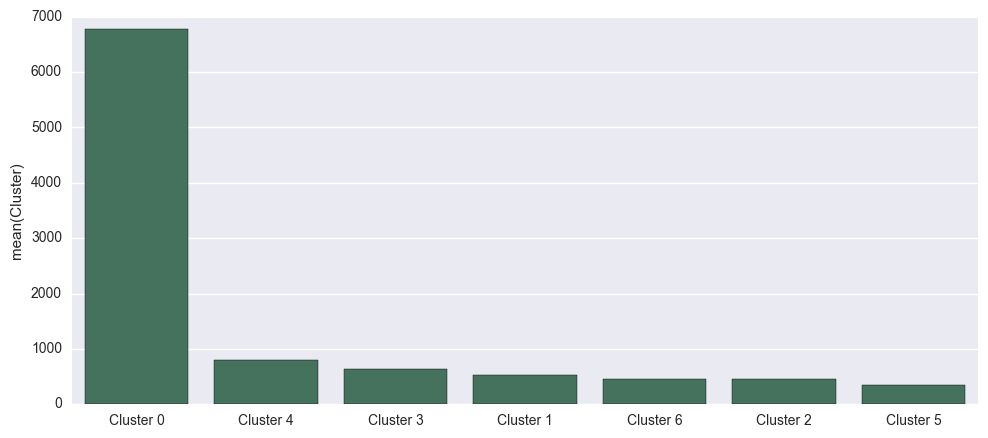

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=sample_text_new_cluster["Cluster"].value_counts(), x=sample_text_new_cluster["Cluster"].value_counts().index, 
            color="#3E795C")

In [60]:
rank = 1
for index in pd.DataFrame(sample_text_new_cluster["Cluster"].value_counts()).index:
    print(index + " (Rank " + str(rank) + "): ")
    return_top_n_words(dtm_idf_df, index, clusters_idf, 30)
    rank += 1

Cluster 0 (Rank 1): 
jquery model display property content custom url field format event android parameter store compile html default directory folder database control plugin reference path request site click execute json api system
Cluster 4 (Rank 2): 
query database field mysql sql insert store display join sql_server model html sql_query group format primary delete foreign cell retrieve jquery design customer sort execute statement mysql_query mysql_database entity product
Cluster 3 (Rank 3): 
service module activity eclipse api android interface spring exception client proce location display folder xml arraylist reference acce request node event servlet constructor web_service path database resource format deploy netbean
Cluster 1 (Rank 4): 
link html acce jquery button url click display browser site content ajax website request event property document regex parameter onclick external api alert style figure execute hide when_click firefox chrome
Cluster 6 (Rank 5): 
android device 

In [61]:
# count_idf_tsne = get_tsne_from_dtm(dtm_idf, dtm_idf_df)

In [62]:
count_idf_tsne_df = pd.DataFrame(count_idf_tsne, index=sample_text.index, columns=['x', 'y'])
count_idf_tsne_df["Cluster"] = clusters_idf

In [63]:
count_idf_tsne_df.head(5)

,x,y,Cluster
Id,,,
25677620,-0.508785,5.047185,Cluster 0
34670240,1.367816,5.935806,Cluster 3
10779020,-0.330033,0.497653,Cluster 0
18389310,-0.994484,1.971171,Cluster 0
33531070,-1.925290,5.528073,Cluster 0


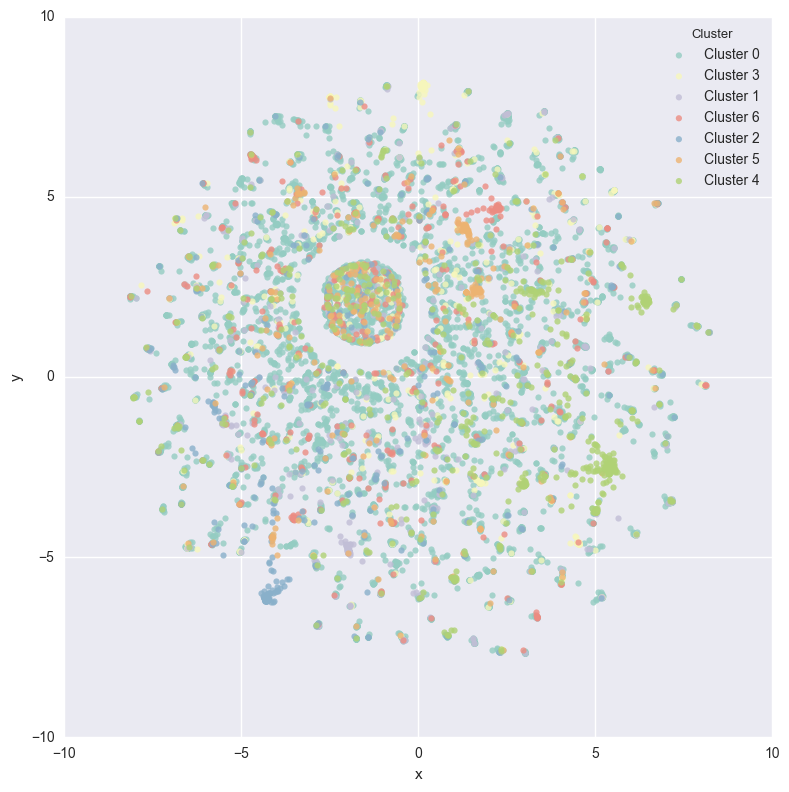

In [64]:
sns.lmplot("x", "y", data=count_idf_tsne_df, hue="Cluster", fit_reg=False, aspect=1.0, size=8, legend_out=False)

In [65]:
sample_text_new_cluster["Tf-idf Score"] = dtm_idf_df.sum(axis=1)

In [66]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 0", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
11118030,Cluster 0,Describe the transition to SaaS model,Describe the transition to SaaS model What is...,5.898466
8387880,Cluster 0,Internet Explorer PDF Reader,Internet Explorer PDF Reader I apologize for ...,5.788285
25275070,Cluster 0,Export an `OBJC_CLASS` from one static lib as ...,Export an `OBJC_CLASS` from one static lib as ...,5.766793
15257880,Cluster 0,IIS 7.5 is prompting for a username and password,IIS 7.5 is prompting for a username and passwo...,5.739219
24053900,Cluster 0,Efficient way to aggregate and remove duplicat...,Efficient way to aggregate and remove duplicat...,5.653256


In [67]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 1", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
32131580,Cluster 1,Breakpoints not hit in javascript files in Vis...,Breakpoints not hit in javascript files in Vis...,5.268712
11596500,Cluster 1,formPanel inside a button in extjs 3.4,formPanel inside a button in extjs 3.4 after ...,4.871430
12960410,Cluster 1,Why does Chrome block my swiping attempts on m...,Why does Chrome block my swiping attempts on m...,4.845089
21763470,Cluster 1,jasmine-jquery loadFixtures with Jasmine 2.0 w...,jasmine-jquery loadFixtures with Jasmine 2.0 w...,4.501794
13918020,Cluster 1,"Javascript not working in FireFox for Android,...","Javascript not working in FireFox for Android,...",4.363135


In [68]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 2", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
31279660,Cluster 2,Android - ImageView - Multiple Screen Support ...,Android - ImageView - Multiple Screen Support ...,4.417362
5339100,Cluster 2,How to map 2D coordinates from store image to ...,How to map 2D coordinates from store image to ...,4.300485
3277180,Cluster 2,Image uploading with PHP,Image uploading with PHP I've been building a...,4.279909
13497700,Cluster 2,PHP libgd crash without feedback,PHP libgd crash without feedback I'm working ...,4.262210
29181440,Cluster 2,android animating views between pages,android animating views between pages I have ...,4.243277


In [69]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 3", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
18706970,Cluster 3,What could cause a sudden ClassNotFoundExcepti...,What could cause a sudden ClassNotFoundExcepti...,6.144948
1099430,Cluster 3,Returning A Value To a Swing Class from anothe...,Returning A Value To a Swing Class from anothe...,4.998198
13475900,Cluster 3,Implement custom security/filters on a part of...,Implement custom security/filters on a part of...,4.809047
4927760,Cluster 3,"Heavy php operations in an http request, reali...","Heavy php operations in an http request, reali...",4.718923
9793970,Cluster 3,"JBoss 5.1GA, Spring 3, invoking methods in dif...","JBoss 5.1GA, Spring 3, invoking methods in dif...",4.648790


In [70]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 4", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
784010,Cluster 4,What is the most practical Solution to Data Ma...,What is the most practical Solution to Data Ma...,6.538302
1654140,Cluster 4,ORM/Persistence layer Advice,ORM/Persistence layer Advice Hi all I'm star...,5.302265
25438730,Cluster 4,Workflow for a basic database query webapp,Workflow for a basic database query webapp I'...,5.263815
22059240,Cluster 4,Resolve conflict between two simple forms on t...,Resolve conflict between two simple forms on t...,5.161837
23314530,Cluster 4,Big data indexing advice on SQL Server,Big data indexing advice on SQL Server I am a...,4.490845


In [71]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 5", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
37333900,Cluster 5,WebRTC DataChannel: working in Firefox but not...,WebRTC DataChannel: working in Firefox but not...,5.797566
38638320,Cluster 5,How to configure Text to PDF programe as Print...,How to configure Text to PDF programe as Print...,5.536969
2201150,Cluster 5,Should I map a DTO to/from a domain entity on ...,Should I map a DTO to/from a domain entity on ...,5.451333
10633830,Cluster 5,Should the AWS Token Vending Machine be deploy...,Should the AWS Token Vending Machine be deploy...,5.383726
21824890,Cluster 5,Moving from Session-based token mechanism to O...,Moving from Session-based token mechanism to O...,5.341101


In [72]:
get_top_n_qns_from_cluster_m(sample_text_new_cluster, cluster="Cluster 6", num=5)

,Cluster,Title,Text for Analysis (Title + Body Exc. Code),Tf-idf Score
Id,,,,
37015510,Cluster 6,trying to create a directory in my bitnami odo...,trying to create a directory in my bitnami odo...,5.384007
1969800,Cluster 6,Web service fails (401 Unauthorized) on one se...,Web service fails (401 Unauthorized) on one se...,4.879934
6325500,Cluster 6,m2eclipse/Eclipse/WTP: Create a container proj...,m2eclipse/Eclipse/WTP: Create a container proj...,4.626228
30484270,Cluster 6,How to do BG NW download after geofence didEnt...,How to do BG NW download after geofence didEnt...,4.469768
25718900,Cluster 6,Web console for docker container,Web console for docker container Situation ...,4.393517


#  

# 3. Implementing Latent Dirichlet Allocation (LDA)

In [73]:
import pyLDAvis
import pyLDAvis.gensim
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from gensim.corpora import Dictionary, MmCorpus
    from gensim.models import Phrases
    from gensim.models.ldamulticore import LdaMulticore
    from gensim.models.phrases import Phraser
    from gensim.models.word2vec import LineSentence

In [74]:
%store -r python_questions_sentences
%store -r python_answers_sentences
%store -r python_questions_sentences_cleaned_list
%store -r python_answers_sentences_cleaned_list
%store -r python_questions_sentences_cleaned_dict
%store -r python_answers_sentences_cleaned_dict
%store -r python_questions_doc_term_matrix
%store -r python_answers_doc_term_matrix
%store -r python_questions_lda
%store -r python_questions_lda_vis
%store -r python_answers_lda
%store -r python_answers_lda_vis

%store -r stack_questions_sentences
%store -r stack_answers_sentences
%store -r stack_questions_sentences_cleaned_list
%store -r stack_answers_sentences_cleaned_list
%store -r stack_questions_sentences_cleaned_dict
%store -r stack_answers_sentences_cleaned_dict
%store -r stack_questions_doc_term_matrix
%store -r stack_answers_doc_term_matrix
%store -r stack_questions_lda
%store -r stack_answers_lda
%store -r stack_questions_lda_vis
%store -r stack_answers_lda_vis

## 3.1. Summarizing Phrases and Building Dictionary from Text

## 3.1.1 Python Questions and Answers

In [75]:
# python_questions_sentences = pd.Series(converting_token_to_trigram_sentences(python_questions_cleaned, "Text for Analysis (Title + Body Exc. Code)"), index=python_questions_cleaned.index).apply(lambda x: " ".join(x))
# python_answers_sentences = pd.Series(converting_token_to_trigram_sentences(python_answers_cleaned, "Body Exc. Code"), index=python_answers_cleaned.index).apply(lambda x: " ".join(x))
# python_questions_sentences_cleaned_list = list(python_questions_sentences.apply(remove_stop_words))
# python_answers_sentences_cleaned_list = list(python_answers_sentences.apply(remove_stop_words))

In [76]:
# python_questions_sentences_cleaned_dict = Dictionary(python_questions_sentences_cleaned_list)
# python_answers_sentences_cleaned_dict = Dictionary(python_answers_sentences_cleaned_list)

In [77]:
# python_questions_doc_term_matrix = [python_questions_sentences_cleaned_dict.doc2bow(doc) for doc in python_questions_sentences_cleaned_list]
# python_answers_doc_term_matrix = [python_answers_sentences_cleaned_dict.doc2bow(doc) for doc in python_answers_sentences_cleaned_list]

## 3.1.2. StackOverflow Questions and Answers

In [78]:
# Removing some of the stop words before proceeding
# stack_questions_sentences = pd.Series(converting_token_to_trigram_sentences(stack_questions_cleaned, "Text for Analysis (Title + Body Exc. Code)"), index=stack_questions_cleaned.index).apply(lambda x: " ".join(x))
# stack_answers_sentences = pd.Series(converting_token_to_trigram_sentences(stack_answers_cleaned, "Body Exc. Code"), index=stack_answers_cleaned.index).apply(lambda x: " ".join(x))
# stack_questions_sentences_cleaned_list = list(stack_questions_sentences.apply(remove_stop_words))
# stack_answers_sentences_cleaned_list = list(stack_answers_sentences.apply(remove_stop_words))

In [79]:
# stack_questions_sentences_cleaned_dict = Dictionary(stack_questions_sentences_cleaned_list)
# stack_answers_sentences_cleaned_dict = Dictionary(stack_answers_sentences_cleaned_list)
# stack_questions_doc_term_matrix = [stack_questions_sentences_cleaned_dict.doc2bow(doc) for doc in stack_questions_sentences_cleaned_list]
# stack_answers_doc_term_matrix = [stack_answers_sentences_cleaned_dict.doc2bow(doc) for doc in stack_answers_sentences_cleaned_list]

## 3.2. Topic Modelling and KMeans Clustering by Cosine Similarity

## 3.2.1. Python Questions and Answers

## 3.2.1.1. Building LDA Models

In [80]:
# python_questions_lda = LdaMulticore(python_questions_doc_term_matrix, num_topics=30, id2word=python_questions_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# python_answers_lda = LdaMulticore(python_answers_doc_term_matrix, num_topics=30, id2word=python_answers_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# python_questions_lda_vis = pyLDAvis.gensim.prepare(python_questions_lda, python_questions_doc_term_matrix, python_questions_sentences_cleaned_dict)
# python_answers_lda_vis = pyLDAvis.gensim.prepare(python_answers_lda, python_answers_doc_term_matrix, python_answers_sentences_cleaned_dict)

## 3.2.1.2. Visualizing Models

In [81]:
pyLDAvis.display(python_questions_lda_vis)

In [82]:
pyLDAvis.display(python_answers_lda_vis)

## 3.2.2. StackOverflow Questions and Answers

## 3.2.2.1. Building LDA Models

In [83]:
# stack_answers_lda = LdaMulticore(stack_answers_doc_term_matrix, num_topics=30, id2word=stack_answers_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# stack_questions_lda = LdaMulticore(stack_questions_doc_term_matrix, num_topics=30, id2word=stack_questions_sentences_cleaned_dict, workers=3, passes=5, chunksize=2000)
# stack_answers_lda_vis = pyLDAvis.gensim.prepare(stack_answers_lda, stack_answers_doc_term_matrix, stack_answers_sentences_cleaned_dict)
# stack_questions_lda_vis = pyLDAvis.gensim.prepare(stack_questions_lda, stack_questions_doc_term_matrix, stack_questions_sentences_cleaned_dict)

## 3.2.2.2. Visualizing Models

In [84]:
pyLDAvis.display(stack_questions_lda_vis)

In [85]:
pyLDAvis.display(stack_answers_lda_vis)

# 4. NLTK and Scikit-Learn K-Means Clustering

In [89]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import nltk

In [90]:
def get_clusters_new(X, df, n_cluster, n_repeat):
    clusterer = nltk.cluster.KMeansClusterer(n_cluster, nltk.cluster.util.cosine_distance, repeats=n_repeat, avoid_empty_clusters=True)
    clusterer.cluster(X)
    clusters = {}
    df_matrix = df.as_matrix()
    for index in df.index:
        clusters[index] = "Cluster " + str(clusterer.classify(df_matrix[index]))
    return pd.Series(clusters, index=df.index)
    
def get_topic_distribution(lda, dtm):
    dic = {}
    for index, item in enumerate(lda[dtm]):
        temp_dic = {}
        for pair in item:
            temp_dic[pair[0]] = pair[1]
        dic[index] = temp_dic
    df = pd.DataFrame.from_dict(dic).T
    return df.reindex_axis(sorted(df.columns), axis=1)

def return_top_n_topics_in_cluster(topic_lda, topic_df, cluster_df, cluster_index, top_n=5):
    top_topic = topic_df[topic_df.index.isin(cluster_df[cluster_df=="Cluster "+str(cluster_index)].index)]
    top_topic_sorted = top_topic.mean().sort_values(ascending=False)[:top_n]
    for index in top_topic_sorted.index:
        print(list(map(lambda x: x[0], topic_lda.show_topic(index))))

In [91]:
%store -r clusters_nltk
%store -r python_question_topic_df
%store -r python_answer_topic_df
%store -r stack_question_topic_df
%store -r stack_answer_topic_df

In [92]:
# python_question_topic_df = get_topic_distribution(python_questions_lda, python_questions_doc_term_matrix)
# python_question_topic_df.fillna(0, inplace=True)
python_question_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.205242,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.172753,0.0,0.461601,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.129167,0.000000,0.129167,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.173406,0.000000,0.0,0.000000,0.0,0.454329,0.259006
3,0.0,0.0,0.0,0.0,0.0,0.081764,0.241340,0.354985,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.157926,0.415931,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [93]:
# python_answer_topic_df = get_topic_distribution(python_answers_lda, python_answers_doc_term_matrix)
# python_answer_topic_df.fillna(0, inplace=True)
python_answer_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.264478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.252188,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.011111,0.344444,0.011111,0.011111,0.011111,0.344444,0.011111,0.011111,0.011111,0.011111,...,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111
2,0.000000,0.128166,0.000000,0.000000,0.000000,0.000000,0.000000,0.103333,0.101935,0.000000,...,0.000000,0.000000,0.000000,0.279893,0.000000,0.000000,0.000000,0.303339,0.000000,0.000000
3,0.000000,0.000000,0.297401,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.086716,0.000000,0.000000,0.268508,0.000000,0.000000,0.000000
4,0.000000,0.136674,0.107128,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.139977,0.000000,0.000000,0.080326,0.000000,0.000000,0.000000


In [94]:
# stack_question_topic_df = get_topic_distribution(stack_questions_lda, stack_questions_doc_term_matrix)
# stack_question_topic_df.fillna(0, inplace=True)
stack_question_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.033848,0.000000,0.0,0.197531,0.0,0.243013,0.122618,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.075783,0.038935,0.0,0.037489,0.146092
1,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.353298,...,0.000000,0.0,0.000000,0.0,0.321114,0.000000,0.000000,0.0,0.016554,0.075206
2,0.000000,0.000000,0.191599,0.0,0.000000,0.0,0.078314,0.000000,0.000000,0.000000,...,0.168612,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.106731,0.000000,0.000000,0.0,0.110656,0.0,0.000000,0.000000,0.000000,0.250664,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.219332,0.000000
4,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.185526,0.235274,0.000000,...,0.000000,0.0,0.291726,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [95]:
# stack_answer_topic_df = get_topic_distribution(stack_answers_lda, stack_answers_doc_term_matrix)
# stack_answer_topic_df.fillna(0, inplace=True)
stack_answer_topic_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.172222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.172222,0.000000
1,0.000000,0.000000,0.040575,0.000000,0.034103,0.857596,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040642,0.000000
2,0.000000,0.000000,0.000000,0.338889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.172222,0.000000,0.000000,0.000000,0.000000,0.338889,0.000000,0.000000,0.000000
3,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,...,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.299797,0.000000,...,0.000000,0.000000,0.000000,0.165097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 4.1. Trial Stage with NLTK and Scikit-Learn K-Means

In [96]:
# sample_df = python_question_topic_df.sample(n=50000).reset_index().drop("index", axis=1)
# sample_matrix = [element for element in sample_df.as_matrix()]
%store -r sample_df
sample_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.032634,0.000000,0.0,0.624983,0.0,0.0,0.044332,0.0,0.072424,0.000000,...,0.0,0.0,0.022208,0.000000,0.000000,0.074231,0.000000,0.000000,0.000000,0.043262
1,0.292495,0.055323,0.0,0.055928,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.115376,0.000000,0.000000,0.000000,0.160965,0.000000,0.000000
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.129167,0.000000,0.379024,0.000000
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.425305,...,0.0,0.0,0.000000,0.000000,0.160844,0.285280,0.000000,0.000000,0.000000,0.000000
4,0.806667,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 4.1.1. NLTK Clustering by Cosine Similarity

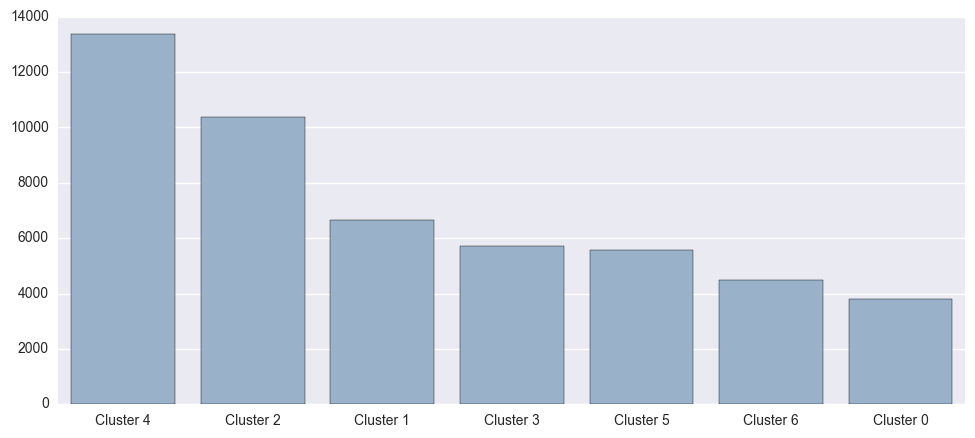

In [97]:
# clusters_nltk = get_clusters_new(sample_matrix, sample_df, 7, 1)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=clusters_nltk.value_counts(), x=clusters_nltk.value_counts().index, 
            color="#91B2D2")

## 4.1.2. Scikit-Learn Clustering by Normalized Euclidean Distance

In [98]:
sample_df_norm = pd.DataFrame(normalize(sample_df), index=sample_df.index, columns=sample_df.columns)
sample_df_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.05101,0.000000,0.0,0.976919,0.0,0.0,0.069297,0.0,0.113208,0.000000,...,0.0,0.0,0.034714,0.000000,0.000000,0.116032,0.000000,0.000000,0.000000,0.067624
1,0.72004,0.136189,0.0,0.137679,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.284021,0.000000,0.000000,0.000000,0.396249,0.000000,0.000000
2,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.262731,0.000000,0.770953,0.000000
3,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.792317,...,0.0,0.0,0.000000,0.000000,0.299642,0.531459,0.000000,0.000000,0.000000,0.000000
4,1.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=7,
        n_init=3, random_state=32432, reassignment_ratio=0.01, tol=0.0,
        verbose=0)


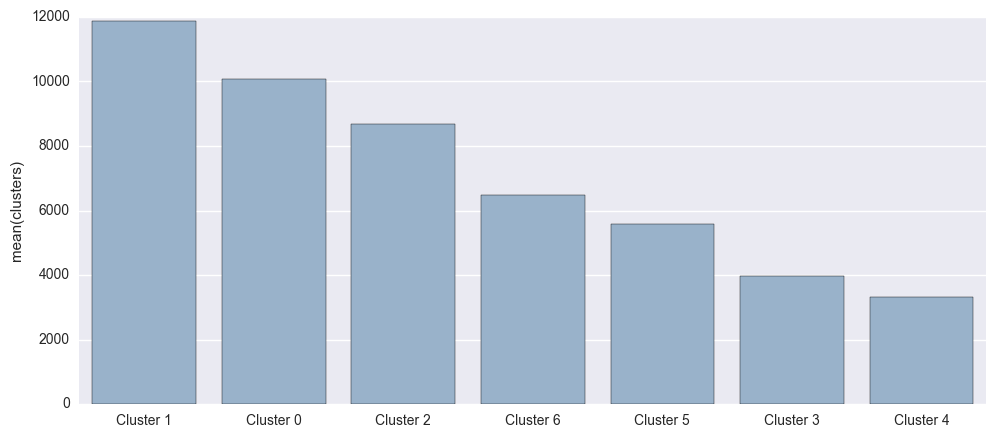

In [99]:
clusters_kmeans_norm = get_clusters(sample_df_norm, sample_df_norm.index, n_cluster=7, random_state=32432)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=clusters_kmeans_norm.value_counts(), x=clusters_kmeans_norm.value_counts().index, 
            color="#91B2D2")

## 4.2. K-Means

In [100]:
def get_pca(df):
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df)
    df_pca_df = pd.DataFrame(df_pca)
    df_pca_df.columns = ["x", "y"]
    return df_pca_df

def return_normalized_df(df):
    return pd.DataFrame(normalize(df), index=df.index, columns=df.columns)

## 4.2.1. Python Questions and Answers

## 4.2.1.1. Python Questions

In [101]:
%store -r python_question_topic_df_norm
%store -r python_questions_clusters
%store -r python_question_topic_df_pca

In [102]:
# python_question_topic_df_norm = return_normalized_df(python_question_topic_df)
python_question_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.379286,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.319246,0.0,0.853035,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.234177,0.000000,0.234177,0.0,0.000000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.312554,0.000000,0.0,0.000000,0.0,0.818899,0.466842


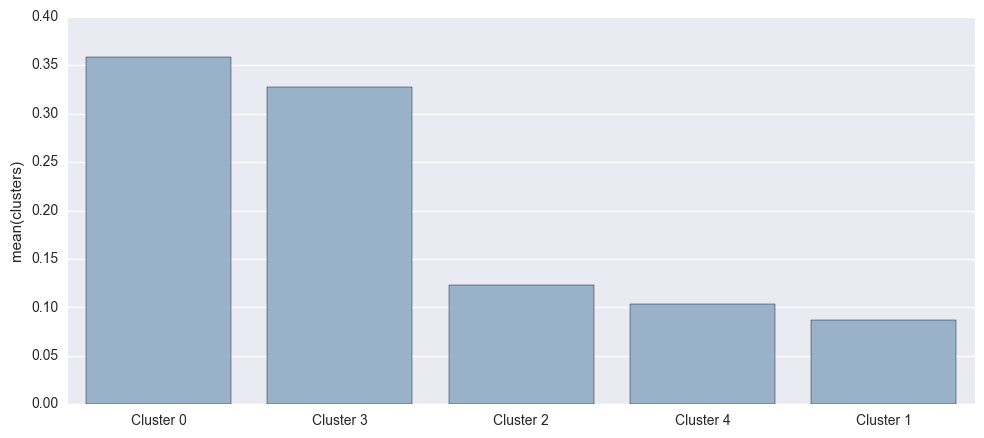

In [103]:
# python_questions_clusters = get_clusters(python_question_topic_df_norm, python_question_topic_df_norm.index, n_cluster=5, random_state=75414)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=python_questions_clusters.value_counts()/python_questions_clusters.value_counts().sum(), x=python_questions_clusters.value_counts().index.astype(str), 
            color="#91B2D2")

In [104]:
# python_question_topic_df_pca = get_pca(python_question_topic_df)
python_question_topic_df_pca["Cluster"] = python_questions_clusters
python_question_topic_df_pca.head()

,x,y,Cluster
0,-0.007063,0.041330,Cluster 3
1,0.064605,0.016146,Cluster 4
2,0.013223,0.009209,Cluster 0
3,-0.056117,-0.036117,Cluster 0
4,-0.034290,0.076808,Cluster 3


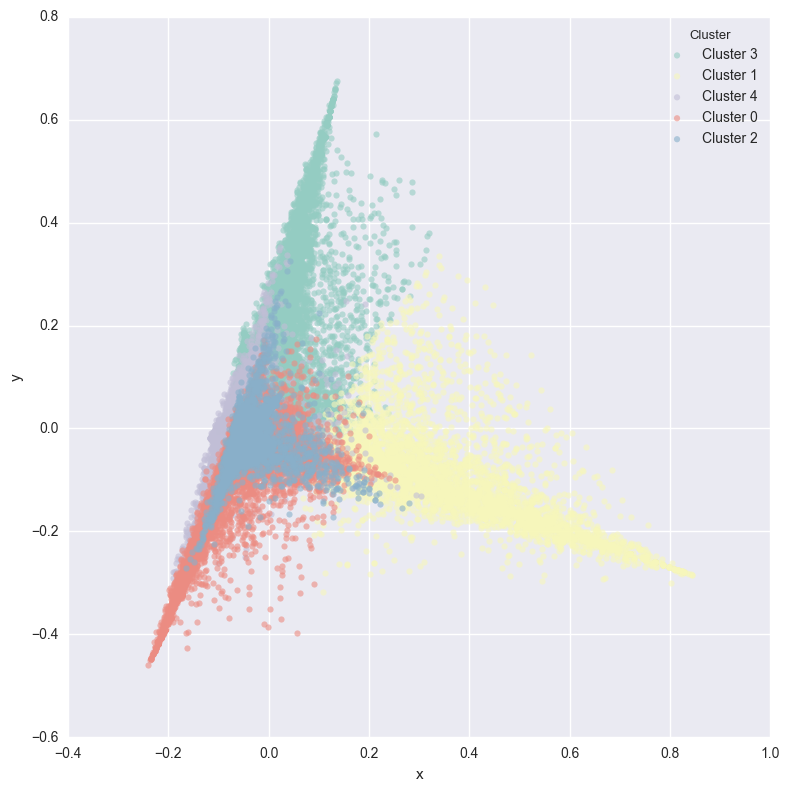

In [105]:
sns.lmplot(y="y", x="x", data=python_question_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

In [106]:
print("Top Topics in Clusters Ranked by Percentage: ")
for index in python_questions_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(python_questions_lda, python_question_topic_df, python_questions_clusters, int(index[-1]), 5)

Top Topics in Clusters Ranked by Percentage: 
Cluster 0: 
['plot', 'matplotlib', 'matrix', 'graph', 'figure', 'coordinate', 'vector', 'shape', 'color', 'chart']
['group', 'numpy', 'numpy_array', 'datum_frame', 'digit', 'matlab', 'mode', 'frequency', 'maximum', 'book']
['feature', 'assign', 'dataset', 'sample', 'tensorflow', 'slice', 'train', 'scikit_learn', 'training', 'sklearn']
['table', 'database', 'format', 'insert', 'query', 'mysql', 'sqlalchemy', 'excel', 'entry', 'sqlite']
['csv', 'compare', 'repeat', 'fast', 'combination', 'calculation', 'valueerror', 'speed', 'nltk', 'attributeerror']
Cluster 3: 
['app', 'url', 'django', 'flask', 'server', 'site', 'request', 'redirect', 'static', 'deploy']
['directory', 'path', 'folder', 'copy', 'location', 'virtualenv', 'root', 'random', 'system', 'rename']
['link', 'html', 'website', 'selenium', 'url', 'email', 'scrapy', 'anaconda', 'javascript', 'webpage']
['source', 'compile', 'machine', 'parallel', 'core', 'cython', 'support', 'dependency

## 4.2.1.2. Python Answers

In [107]:
%store -r python_answer_topic_df_norm
%store -r python_answers_clusters
%store -r python_answer_topic_df_pca

In [108]:
# python_answer_topic_df_norm = return_normalized_df(python_answer_topic_df)
python_answer_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,0.590972,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.563511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.022646,0.702012,0.022646,0.022646,0.022646,0.702012,0.022646,0.022646,0.022646,0.022646,...,0.022646,0.022646,0.022646,0.022646,0.022646,0.022646,0.022646,0.022646,0.022646,0.022646
2,0.000000,0.281124,0.000000,0.000000,0.000000,0.000000,0.000000,0.226655,0.223588,0.000000,...,0.000000,0.000000,0.000000,0.613928,0.000000,0.000000,0.000000,0.665356,0.000000,0.000000


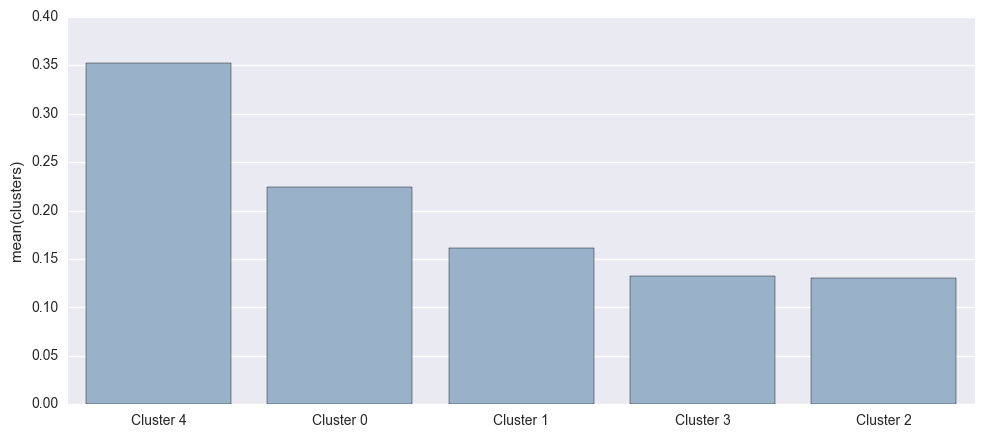

In [109]:
# python_answers_clusters = get_clusters(python_answer_topic_df_norm, python_answer_topic_df_norm.index, n_cluster=5, random_state=37683)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 5)
sns.barplot(y=python_answers_clusters.value_counts()/python_answers_clusters.value_counts().sum(), x=python_answers_clusters.value_counts().index.astype(str), 
            color="#91B2D2")

In [110]:
# python_answer_topic_df_pca = get_pca(python_answer_topic_df)
python_answer_topic_df_pca["Cluster"] = python_answers_clusters
python_answer_topic_df_pca.head()

,x,y,Cluster
0,0.115570,0.200249,Cluster 4
1,-0.028240,0.020430,Cluster 4
2,0.112428,0.211352,Cluster 2
3,0.004374,0.071379,Cluster 2
4,0.029346,0.112112,Cluster 2


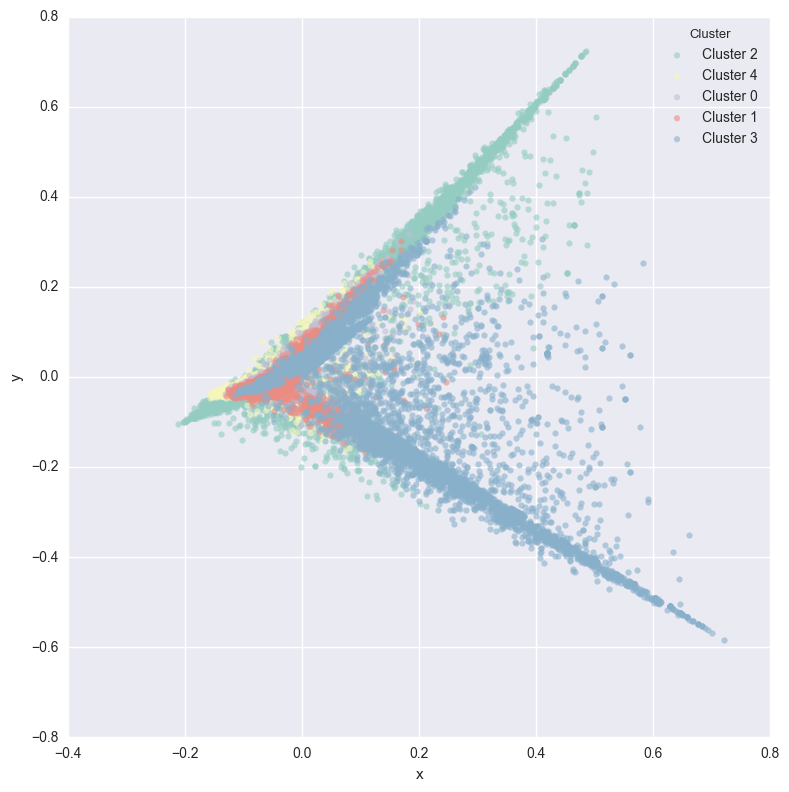

In [113]:
sns.lmplot(y="y", x="x", data=python_answer_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

In [114]:
print("Top Topics in Clusters Ranked by Percentage: ")
for index in python_answers_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(python_answers_lda, python_answer_topic_df, python_answers_clusters, int(index[-1]), 5)

Top Topics in Clusters Ranked by Percentage: 
Cluster 4: 
['support', 'document', 'feature', 'compile', 'xml', 'release', 'upgrade', 'indentation', 'github', 'source']
['approach', 'parse', 'condition', 'generator', 'algorithm', 'csv', 'counter', 'tree', 'merge', 'repeat']
['replace', 'numpy', 'list_comprehension', 'slice', 'numpy_array', 'indexing', 'opencv', 'iterate_through', 'iterate', 'pointer']
['regex', 'link', 'pattern', 'context', 'regular_expression', 'group', 'capture', 'java', 'score', 'beautifulsoup']
['space', 'figure', 'plot', 'frame', 'insert', 'matplotlib', 'color', 'anaconda', 'groupby', 'patch']
Cluster 0: 
['format', 'image', 'tuple', 'sort', 'content', 'join', 'html', 'extract', 'pixel', 'pycharm']
['path', 'folder', 'system', 'digit', 'directory', 'decorator', 'operator', 'mode', 'extension', 'executable']
['split', 'json', 'quote', 'trick', 'initialize', 'escape', 'pickle', 'builtin', 'literal', 'recursive']
['syntax', 'expression', 'evaluate', 'keyword', 'style'

## 4.2.1.3. StackOverflow Questions and Answers

In [115]:
%store -r stack_question_topic_df_norm
%store -r stack_answer_topic_df_norm
%store -r stack_questions_clusters
%store -r stack_answers_clusters
%store -r stack_question_topic_df_pca
%store -r stack_answer_topic_df_pca

In [116]:
# stack_question_topic_df_norm = return_normalized_df(stack_question_topic_df)
stack_question_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.088098,0.000000,0.0,0.514125,0.0,0.632504,0.319146,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.197245,0.101338,0.0,0.097574,0.380243
1,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.689742,...,0.000000,0.0,0.0,0.0,0.626909,0.000000,0.000000,0.0,0.032318,0.146825
2,0.0,0.000000,0.357232,0.0,0.000000,0.0,0.146015,0.000000,0.0,0.000000,...,0.314372,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [117]:
# stack_answer_topic_df_norm = return_normalized_df(stack_answer_topic_df)
stack_answer_topic_df_norm.head(3)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.381468,0.0,0.0,0.0,0.0,0.000000,0.0,0.381468,0.0
1,0.0,0.0,0.04717,0.000000,0.039646,0.996981,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.047248,0.0
2,0.0,0.0,0.00000,0.665446,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.338177,0.0,0.0,0.0,0.0,0.665446,0.0,0.000000,0.0


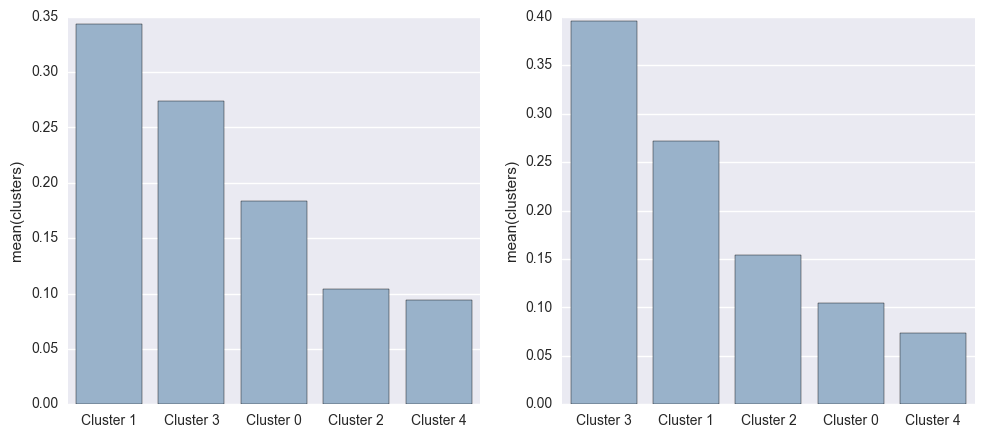

In [118]:
# stack_questions_clusters = get_clusters(stack_question_topic_df_norm, stack_question_topic_df_norm.index, n_cluster=5, random_state=46002)
# stack_answers_clusters = get_clusters(stack_answer_topic_df_norm, stack_answer_topic_df_norm.index, n_cluster=5, , random_state=4455)
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(11.7, 5)
sns.barplot(y=stack_questions_clusters.value_counts()/stack_questions_clusters.value_counts().sum(), x=stack_questions_clusters.value_counts().index.astype(str), 
            color="#91B2D2", ax=ax[0])
sns.barplot(y=stack_answers_clusters.value_counts()/stack_answers_clusters.value_counts().sum(), x=stack_answers_clusters.value_counts().index.astype(str), 
            color="#91B2D2", ax=ax[1])

In [119]:
# stack_question_topic_df_pca = get_pca(stack_question_topic_df)
stack_question_topic_df_pca["Cluster"] = stack_questions_clusters
stack_question_topic_df_pca.head()

,x,y,Cluster
0,-0.021576,-0.075476,Cluster 0
1,-0.102672,0.133271,Cluster 3
2,-0.014979,-0.097506,Cluster 1
3,-0.096427,0.157757,Cluster 3
4,-0.052989,0.028808,Cluster 3


In [120]:
# stack_answer_topic_df_pca = get_pca(stack_answer_topic_df)
stack_answer_topic_df_pca["Cluster"] = stack_answers_clusters
stack_answer_topic_df_pca.head()

,x,y,Cluster
0,0.107439,0.018808,Cluster 2
1,-0.300329,-0.270949,Cluster 3
2,-0.017228,-0.088558,Cluster 2
3,0.019776,-0.010400,Cluster 3
4,0.012702,-0.037885,Cluster 3


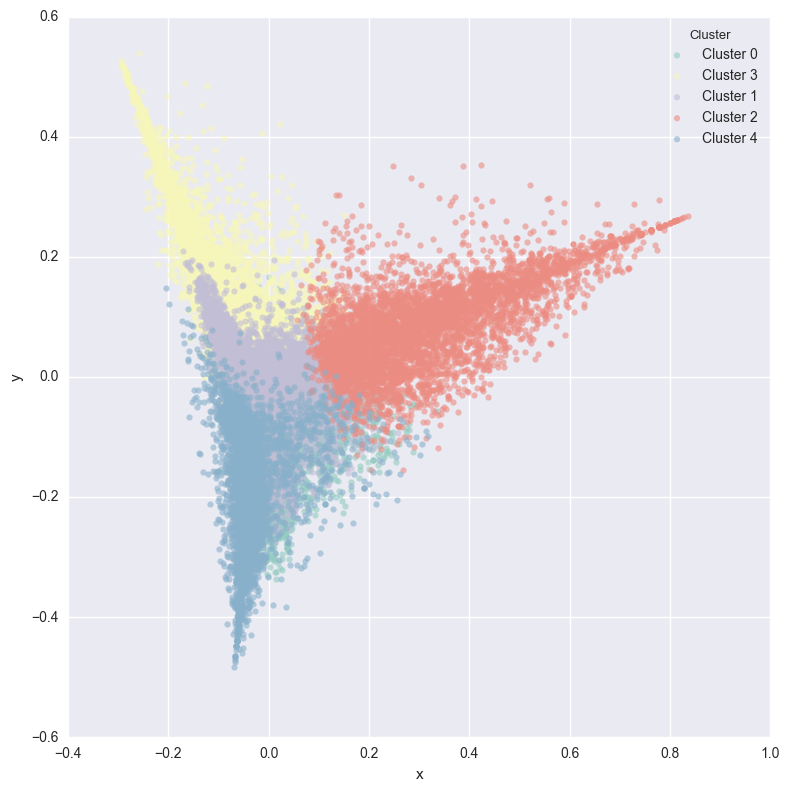

In [123]:
sns.lmplot(y="y", x="x", data=stack_question_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

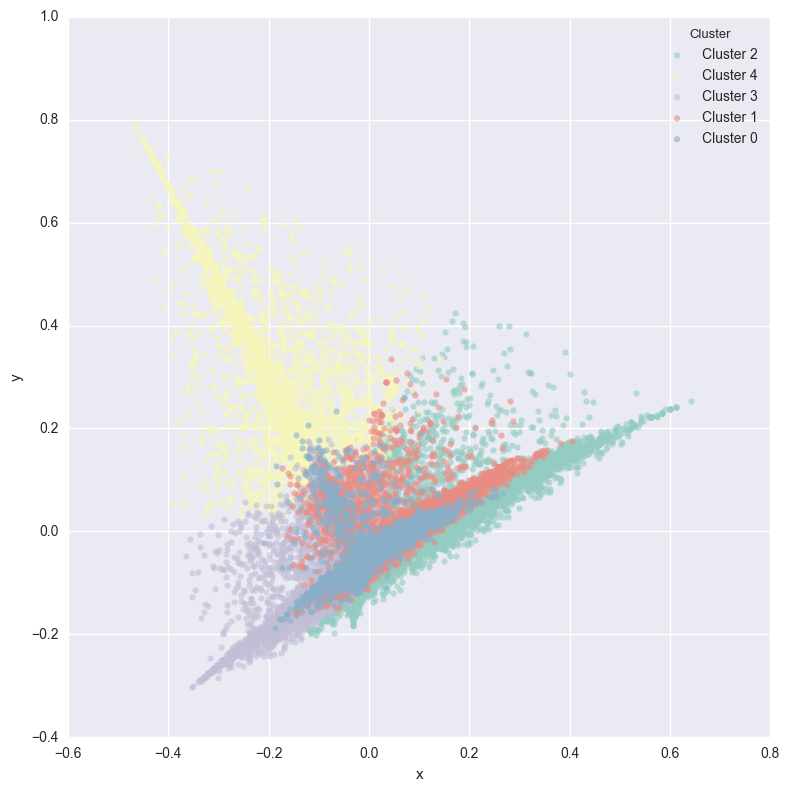

In [125]:
sns.lmplot(y="y", x="x", data=stack_answer_topic_df_pca.sample(n=50000), fit_reg=False, size=8, aspect=1, hue="Cluster", 
           scatter_kws={"alpha": 0.6}, legend=True, legend_out=False)

In [126]:
print("Top Topics in Clusters Ranked by Percentage (Questions): ")
for index in stack_questions_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(stack_questions_lda, stack_question_topic_df, stack_questions_clusters, int(index[-1]), 5)

Top Topics in Clusters Ranked by Percentage (Questions): 
Cluster 1: 
['server', 'client', 'connect', 'connection', 'request', 'host', 'cache', 'machine', 'network', 'port']
['app', 'android', 'device', 'activity', 'crash', 'notification', 'launch', 'phone', 'mongodb', 'develop']
['path', 'compile', 'resource', 'source', 'eclipse', 'configuration', 'spring', 'dependency', 'debug', 'deploy']
['website', 'site', 'web', 'html', 'browser', 'download', 'route', 'category', 'fragment', 'asp.net']
['login', 'account', 'domain', 'password', 'authentication', 'token', 'admin', 'permission', 'username', 'cookie']
Cluster 3: 
['image', 'position', 'background', 'screen', 'picture', 'width', 'center', 'display', 'resize', 'camera']
['button', 'property', 'click', 'bind', 'hide', 'custom', 'layout', 'textbox', 'animation', 'navigation']
['display', 'event', 'click', 'trigger', 'fire', 'dropdown', 'selection', 'widget', 'react', 'gui']
['content', 'xml', 'document', 'style', 'color', 'html', 'body',

In [127]:
print("Top Topics in Clusters Ranked by Percentage (Answers): ")
for index in stack_answers_clusters.value_counts().index:
    print(index + ": ")
    return_top_n_topics_in_cluster(stack_answers_lda, stack_answer_topic_df, stack_answers_clusters, int(index[-1]), 5)

Top Topics in Clusters Ranked by Percentage (Answers): 
Cluster 3: 
['server', 'database', 'client', 'store', 'connection', 'session', 'connect', 'permission', 'account', 'password']
['content', 'html', 'display', 'control', 'height', 'layout', 'render', 'body', 'header', 'container']
['app', 'device', 'console', 'debug', 'apps', 'github', 'launch', 'xcode', 'rail', 'helper']
['property', 'button', 'click', 'folder', 'target', 'menu', 'rename', 'right_click', 'choose', 'background_color']
['compile', 'exception', 'compiler', 'quote', 'operator', 'instruction', 'catch', 'boolean', 'runtime', 'symbol']
Cluster 1: 
['parameter', 'declare', 'constructor', 'assign', 'pointer', 'sort', 'byte', 'initialize', 'member', 'dictionary']
['node', 'memory', 'space', 'span', 'stack', 'buffer', 'structure', 'tree', 'console.log', 'store']
['link', 'url', 'javascript', 'redirect', 'browser', 'href', 'email', 'hide', 'submit', 'html']
['event', 'bind', 'trigger', 'callback', 'container', 'execute', 'han

# 5. Exporting Results for D3.js Visualization

In [128]:
def get_data_for_cluster_vis(original, cluster):
    cluster_series = cluster
    original_df = original
    cluster_series.index = original_df.index
    original_df = original_df.join(pd.DataFrame(cluster_series))
    vis_df = original_df.loc[:, ["CreationDate", "clusters"]]
    vis_df.columns = ["Creation Date", "Clusters"]
    vis_df["Month-Year"] = vis_df["Creation Date"].apply(lambda x: pd.Timestamp(str(x.year) + "-" + str(x.month)))
    vis_df.drop("Creation Date", axis=1, inplace=True)
    for cluster in vis_df["Clusters"].value_counts().index:
        vis_df.loc[vis_df["Clusters"] == cluster, str(cluster)] = 1
        vis_df.loc[vis_df["Clusters"] != cluster, str(cluster)] = 0
    sum_df =  vis_df.drop("Clusters", axis=1).groupby("Month-Year").sum().cumsum()
    final_df = sum_df.apply(lambda x: x/original.shape[0]).reset_index()
    sum_df = sum_df.reset_index()
    final_df["Month-Year"] = final_df["Month-Year"].astype(str)
    sum_df["Month-Year"] = sum_df["Month-Year"].astype(str)
    return (final_df, sum_df)

def rescale(df, scale_n=1000):
    final_df = df.set_index("Month-Year").apply(lambda x: np.floor(x*scale_n)).reset_index()
    return final_df

In [129]:
%store -r python_questions_vis
%store -r python_answers_vis
%store -r stack_questions_vis
%store -r stack_answers_vis

In [134]:
# python_questions_vis = get_data_for_cluster_vis(python_questions_cleaned, python_questions_clusters)
# python_answers_vis = get_data_for_cluster_vis(python_answers_cleaned, python_answers_clusters)
# stack_questions_vis = get_data_for_cluster_vis(stack_questions_cleaned, stack_questions_clusters)
# stack_answers_vis = get_data_for_cluster_vis(stack_answers_cleaned, stack_answers_clusters)

In [135]:
python_questions_vis[1].to_json()

'{"Month-Year":{"0":"2008-10-01","1":"2008-11-01","2":"2008-12-01","3":"2009-01-01","4":"2009-02-01","5":"2009-03-01","6":"2009-04-01","7":"2009-05-01","8":"2009-06-01","9":"2009-07-01","10":"2009-08-01","11":"2009-09-01","12":"2009-10-01","13":"2009-11-01","14":"2009-12-01","15":"2010-01-01","16":"2010-02-01","17":"2010-03-01","18":"2010-04-01","19":"2010-05-01","20":"2010-06-01","21":"2010-07-01","22":"2010-08-01","23":"2010-09-01","24":"2010-10-01","25":"2010-11-01","26":"2010-12-01","27":"2011-01-01","28":"2011-02-01","29":"2011-03-01","30":"2011-04-01","31":"2011-05-01","32":"2011-06-01","33":"2011-07-01","34":"2011-08-01","35":"2011-09-01","36":"2011-10-01","37":"2011-11-01","38":"2011-12-01","39":"2012-01-01","40":"2012-02-01","41":"2012-03-01","42":"2012-04-01","43":"2012-05-01","44":"2012-06-01","45":"2012-07-01","46":"2012-08-01","47":"2012-09-01","48":"2012-10-01","49":"2012-11-01","50":"2012-12-01","51":"2013-01-01","52":"2013-02-01","53":"2013-03-01","54":"2013-04-01","55"

In [136]:
python_answers_vis[1].to_json()

'{"Month-Year":{"0":"2008-10-01","1":"2008-11-01","2":"2008-12-01","3":"2009-01-01","4":"2009-02-01","5":"2009-03-01","6":"2009-04-01","7":"2009-05-01","8":"2009-06-01","9":"2009-07-01","10":"2009-08-01","11":"2009-09-01","12":"2009-10-01","13":"2009-11-01","14":"2009-12-01","15":"2010-01-01","16":"2010-02-01","17":"2010-03-01","18":"2010-04-01","19":"2010-05-01","20":"2010-06-01","21":"2010-07-01","22":"2010-08-01","23":"2010-09-01","24":"2010-10-01","25":"2010-11-01","26":"2010-12-01","27":"2011-01-01","28":"2011-02-01","29":"2011-03-01","30":"2011-04-01","31":"2011-05-01","32":"2011-06-01","33":"2011-07-01","34":"2011-08-01","35":"2011-09-01","36":"2011-10-01","37":"2011-11-01","38":"2011-12-01","39":"2012-01-01","40":"2012-02-01","41":"2012-03-01","42":"2012-04-01","43":"2012-05-01","44":"2012-06-01","45":"2012-07-01","46":"2012-08-01","47":"2012-09-01","48":"2012-10-01","49":"2012-11-01","50":"2012-12-01","51":"2013-01-01","52":"2013-02-01","53":"2013-03-01","54":"2013-04-01","55"

In [137]:
stack_questions_vis[1].to_json()

'{"Month-Year":{"0":"2008-10-01","1":"2008-11-01","2":"2008-12-01","3":"2009-01-01","4":"2009-02-01","5":"2009-03-01","6":"2009-04-01","7":"2009-05-01","8":"2009-06-01","9":"2009-07-01","10":"2009-08-01","11":"2009-09-01","12":"2009-10-01","13":"2009-11-01","14":"2009-12-01","15":"2010-01-01","16":"2010-02-01","17":"2010-03-01","18":"2010-04-01","19":"2010-05-01","20":"2010-06-01","21":"2010-07-01","22":"2010-08-01","23":"2010-09-01","24":"2010-10-01","25":"2010-11-01","26":"2010-12-01","27":"2011-01-01","28":"2011-02-01","29":"2011-03-01","30":"2011-04-01","31":"2011-05-01","32":"2011-06-01","33":"2011-07-01","34":"2011-08-01","35":"2011-09-01","36":"2011-10-01","37":"2011-11-01","38":"2011-12-01","39":"2012-01-01","40":"2012-02-01","41":"2012-03-01","42":"2012-04-01","43":"2012-05-01","44":"2012-06-01","45":"2012-07-01","46":"2012-08-01","47":"2012-09-01","48":"2012-10-01","49":"2012-11-01","50":"2012-12-01","51":"2013-01-01","52":"2013-02-01","53":"2013-03-01","54":"2013-04-01","55"

In [138]:
stack_answers_vis[1].to_json()

'{"Month-Year":{"0":"2008-10-01","1":"2008-11-01","2":"2008-12-01","3":"2009-01-01","4":"2009-02-01","5":"2009-03-01","6":"2009-04-01","7":"2009-05-01","8":"2009-06-01","9":"2009-07-01","10":"2009-08-01","11":"2009-09-01","12":"2009-10-01","13":"2009-11-01","14":"2009-12-01","15":"2010-01-01","16":"2010-02-01","17":"2010-03-01","18":"2010-04-01","19":"2010-05-01","20":"2010-06-01","21":"2010-07-01","22":"2010-08-01","23":"2010-09-01","24":"2010-10-01","25":"2010-11-01","26":"2010-12-01","27":"2011-01-01","28":"2011-02-01","29":"2011-03-01","30":"2011-04-01","31":"2011-05-01","32":"2011-06-01","33":"2011-07-01","34":"2011-08-01","35":"2011-09-01","36":"2011-10-01","37":"2011-11-01","38":"2011-12-01","39":"2012-01-01","40":"2012-02-01","41":"2012-03-01","42":"2012-04-01","43":"2012-05-01","44":"2012-06-01","45":"2012-07-01","46":"2012-08-01","47":"2012-09-01","48":"2012-10-01","49":"2012-11-01","50":"2012-12-01","51":"2013-01-01","52":"2013-02-01","53":"2013-03-01","54":"2013-04-01","55"

# 6. Applying Doc2Vec for Further Insights

In [139]:
import gensim
from functools import reduce
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [140]:
%store -r python_documents
%store -r stack_documents

In [141]:
# python_questions_sentences_df = pd.DataFrame(python_questions_sentences)
# python_questions_sentences_df.columns = ["Question"]
# python_answers_sentences = pd.DataFrame(python_answers_sentences)
# python_answers_sentences.columns = ["Answer"]
# python_answers_sentences["Parent Question Id"] = python_answers_cleaned.ParentId
# python_answers_sentences_group = python_answers_sentences.groupby("Parent Question Id")
# python_answers_sentences_agg = python_answers_sentences_group.aggregate(lambda x: reduce((lambda x, y: x + " " + y), x))["Answer"]
# python_answers_sentences_agg = pd.DataFrame(python_answers_sentences_agg)
# python_sentence_tags = python_tags_new[python_tags_new.index.isin(python_questions_sentences.index)].drop("Tag Count", axis=1)
# python_documents = python_answers_sentences_agg.merge(python_questions_sentences_df, left_index=True, right_index=True)
# python_documents["Document"] = python_documents["Answer"].str.cat(python_documents["Question"], sep=" ")
# python_documents = python_documents.merge(python_sentence_tags, right_index=True, left_index=True)
python_documents.head()

,Answer,Question,Document,Tags
203487,check pyinstaller make standalone_executable f...,create self contain python application create ...,check pyinstaller make standalone_executable f...,"python, windows, executable, self-contained"
203758,what question exactly_what happen when receive...,receive socket size limit good write program p...,what question exactly_what happen when receive...,"python, sockets"
203859,this feature markdown what should post process...,python markdown additionally urlify link when ...,this feature markdown what should post process...,"python, django, markdown"
203912,read about multithread python thread general m...,python support multiprocessor multicore progra...,read about multithread python thread general m...,"python, multicore"
204017,suspect same problem when shortcut window this...,execute program from python os.system fail spa...,suspect same problem when shortcut window this...,"python, shellexecute"


In [142]:
# stack_questions_sentences_df = pd.DataFrame(stack_questions_sentences)
# stack_questions_sentences_df.columns = ["Question"]
# stack_answers_sentences = pd.DataFrame(stack_answers_sentences)
# stack_answers_sentences.columns = ["Answer"]
# stack_answers_sentences["Parent Question Id"] = stack_answers_cleaned.ParentId
# stack_answers_sentences_group = stack_answers_sentences.groupby("Parent Question Id")
# stack_answers_sentences_agg = stack_answers_sentences_group.aggregate(lambda x: reduce((lambda x, y: x + " " + y), x))["Answer"]
# stack_answers_sentences_agg = pd.DataFrame(stack_answers_sentences_agg)
# stack_sentence_tags = stack_tags_new[stack_tags_new.index.isin(stack_questions_sentences.index)].drop("Tag Count", axis=1)
# stack_documents = stack_answers_sentences_agg.merge(stack_questions_sentences_df, left_index=True, right_index=True)
# stack_documents["Document"] = stack_documents["Answer"].str.cat(stack_documents["Question"], sep=" ")
# stack_documents = stack_documents.merge(stack_sentence_tags, right_index=True, left_index=True)
stack_documents.head()

,Answer,Question,Document,Tags
203340,documentation print functionality your browser...,jquery current well_formatted printable docume...,documentation print functionality your browser...,jquery
203520,have consider handle textbox_textchanged_event...,discriminate_between datum bind user action wi...,have consider handle textbox_textchanged_event...,".net, winforms, data-binding"
203590,strangely that option open vcproj_file jedit ...,include directory where setting visual_studio ...,strangely that option open vcproj_file jedit ...,"visual-studio, include"
203620,else inside scriplet base currently select lan...,make bilingual site without create separate pa...,else inside scriplet base currently select lan...,"layout, internationalization"
203640,seem that problem must with httputility.urlenc...,transform link come relative base url render idea,seem that problem must with httputility.urlenc...,xslt


In [143]:
# python_training_document = []
# for index, value in python_documents.iterrows():
    # python_training_document.append(TaggedDocument(words=value[2].split(" "), tags=value[3].split(", ")))
# python_doc2vec_model = Doc2Vec(python_training_document, size=100, window=10, min_count=3, dm=1, workers=3)
%store -r python_training_document
%store -r python_doc2vec_model
python_training_document[np.random.randint(0, len(python_training_document))]

TaggedDocument(words=['kindly', 'check', 'follow', 'fiddle', 'html', 'maybe', 'something_similar', 'here', 'would', 'solve_problem', 'with', 'javascript', 'assume', 'form', 'page', 'have', 'redirect', 'post', 'after', 'post', 'create', 'html', 'prevent', 'user', 'post', 'multiple', 'submission', 'click_submit_button', 'multiple', 'time', 'here', 'problem', 'have', 'when', 'user', 'submit', 'post', 'click_submit_button', 'twice', 'before', 'page', 'load', 'then', 'same', 'post', 'make', 'think', 'could', 'this', 'with', 'python', 'code', 'since', 'django', 'restrict', 'user', 'post', 'only', 'what', 'even', 'after', 'that', 'issue', 'exist', 'here', 'html', 'code', 'with', 'that', 'work'], tags=['javascript', 'jquery', 'python', 'django', 'django-templates'])

In [144]:
# stack_training_document = []
# for index, value in stack_documents.iterrows():
    # stack_training_document.append(TaggedDocument(words=value[2].split(" "), tags=value[3].split(", ")))
# stack_doc2vec_model = Doc2Vec(stack_training_document, size=100, window=10, min_count=3, dm=1, workers=3)
%store -r stack_training_document
%store -r stack_doc2vec_model
stack_training_document[np.random.randint(0, len(stack_training_document))]

TaggedDocument(words=['think', 'your', 'good', 'option', 'heroku', 'from', 'your', 'app', 'folder', 'heroku', 'app', 'appname', 'heroku', 'app', 'appname', 'this', 'also', 'good', 'option', 'debug', 'error', 'heroku', 'that', 'show', 'production_mode', 'locally', 'have', 'issue', 'with', 'app', 'that', 'thing', 'strangely', 'something', 'expect', 'only', 'when', 'push_heroku', 'either', 'development_production_environment', 'locally', 'binding.pry', 'code', 'simply', 'crash', 'heroku', 'debug', 'instance', 'heroku', 'where', 'error', 'show', 'edit', 'view', 'from', 'heroku_heroku', 'tail', 'those', 'production_environment', 'detail', 'development', 'that', 'would_love', 'there', 'anyway', 'retrieve', 'development', 'from', 'heroku', 'view'], tags=['ruby-on-rails', 'ruby-on-rails-4', 'heroku'])

In [145]:
python_doc2vec_model.docvecs.most_similar(positive=['machine-learning'], topn=30)

[('scikit-learn', 0.8307101726531982),
 ('classification', 0.7964718341827393),
 ('svm', 0.7763357162475586),
 ('logistic-regression', 0.7740572690963745),
 ('apache-spark-mllib', 0.7581468820571899),
 ('naivebayes', 0.7373546361923218),
 ('training-data', 0.7205023765563965),
 ('random-forest', 0.7188498973846436),
 ('libsvm', 0.6946261525154114),
 ('supervised-learning', 0.6801104545593262),
 ('bayesian', 0.6796874403953552),
 ('neural-network', 0.6702024936676025),
 ('sentiment-analysis', 0.6619840860366821),
 ('nolearn', 0.6589703559875488),
 ('xgboost', 0.6443291902542114),
 ('perceptron', 0.6433820128440857),
 ('data-mining', 0.6416877508163452),
 ('text-classification', 0.6403294205665588),
 ('document-classification', 0.62953120470047),
 ('multilabel-classification', 0.6292186379432678),
 ('lda', 0.6281919479370117),
 ('deep-learning', 0.6262297034263611),
 ('text-mining', 0.6233618855476379),
 ('svmlight', 0.6205220222473145),
 ('word2vec', 0.6203049421310425),
 ('sklearn-pand

In [146]:
stack_doc2vec_model.docvecs.most_similar(positive=['machine-learning'], topn=30)

[('classification', 0.8452262282371521),
 ('scikit-learn', 0.8341740369796753),
 ('svm', 0.8006922602653503),
 ('neural-network', 0.7764813303947449),
 ('data-mining', 0.7591589093208313),
 ('deep-learning', 0.746607780456543),
 ('weka', 0.744908332824707),
 ('logistic-regression', 0.7396652102470398),
 ('keras', 0.7380706667900085),
 ('bayesian', 0.7282990217208862),
 ('cluster-analysis', 0.7282692193984985),
 ('random-forest', 0.7281560897827148),
 ('cross-validation', 0.704203724861145),
 ('lstm', 0.7040953040122986),
 ('document-classification', 0.6973724365234375),
 ('pybrain', 0.6963382959365845),
 ('vowpalwabbit', 0.6704763770103455),
 ('apache-spark-mllib', 0.6671915054321289),
 ('feature-selection', 0.6659931540489197),
 ('regression', 0.6569206714630127),
 ('artificial-intelligence', 0.6563626527786255),
 ('pymc', 0.6451460719108582),
 ('libsvm', 0.6433382630348206),
 ('k-means', 0.6430644989013672),
 ('encog', 0.6414388418197632),
 ('predict', 0.6400701999664307),
 ('linear-

In [147]:
python_doc2vec_model.docvecs.most_similar(positive=['deep-learning'], topn=30)

[('neural-network', 0.8317225575447083),
 ('keras', 0.8172087669372559),
 ('tensorflow', 0.7905377149581909),
 ('caffe', 0.7412213683128357),
 ('theano', 0.7299360632896423),
 ('pycaffe', 0.694659411907196),
 ('lasagne', 0.6946533918380737),
 ('autoencoder', 0.6748985052108765),
 ('pybrain', 0.6684340834617615),
 ('nolearn', 0.6584459543228149),
 ('conv-neural-network', 0.6544288396835327),
 ('lstm', 0.651523232460022),
 ('machine-learning', 0.6262297034263611),
 ('perceptron', 0.6190846562385559),
 ('training-data', 0.5881494283676147),
 ('recurrent-neural-network', 0.5755982398986816),
 ('backpropagation', 0.5659608840942383),
 ('apache-spark-mllib', 0.5536010265350342),
 ('logistic-regression', 0.5278632044792175),
 ('xgboost', 0.5238665342330933),
 ('word2vec', 0.522842288017273),
 ('dbn', 0.5222949981689453),
 ('mnist', 0.5222780108451843),
 ('scikit-learn', 0.5161768198013306),
 ('svm', 0.5160274505615234),
 ('bayesian', 0.5140833258628845),
 ('pymc3', 0.511245608329773),
 ('hidd

In [148]:
stack_doc2vec_model.docvecs.most_similar(positive=['deep-learning'], topn=30)

[('caffe', 0.8489829301834106),
 ('tensorflow', 0.8217349648475647),
 ('keras', 0.7938655018806458),
 ('conv-neural-network', 0.7759560346603394),
 ('neural-network', 0.7753286361694336),
 ('lstm', 0.7608596086502075),
 ('scikit-learn', 0.758034348487854),
 ('machine-learning', 0.7466077208518982),
 ('svm', 0.7168772220611572),
 ('cross-validation', 0.6872354745864868),
 ('theano', 0.6866600513458252),
 ('vowpalwabbit', 0.6559351086616516),
 ('apache-spark-mllib', 0.6419744491577148),
 ('torch', 0.6381048560142517),
 ('pybrain', 0.6254416704177856),
 ('lasagne', 0.6235384941101074),
 ('classification', 0.6169799566268921),
 ('logistic-regression', 0.6147292852401733),
 ('random-forest', 0.6138907670974731),
 ('document-classification', 0.6094911098480225),
 ('recurrent-neural-network', 0.6039429306983948),
 ('weka', 0.6028356552124023),
 ('lmdb', 0.5994220972061157),
 ('cluster-analysis', 0.5929603576660156),
 ('kriging', 0.5798380374908447),
 ('libsvm', 0.5772777795791626),
 ('sift', 

In [149]:
python_doc2vec_model.docvecs.most_similar(positive=['nlp'], topn=30)

[('nltk', 0.8197640180587769),
 ('text-mining', 0.7860147356987),
 ('sentiment-analysis', 0.7600005865097046),
 ('linguistics', 0.7371411323547363),
 ('text-classification', 0.7349452376365662),
 ('text-analysis', 0.6978338956832886),
 ('textblob', 0.6928622722625732),
 ('n-gram', 0.6728166341781616),
 ('spell-checking', 0.650371253490448),
 ('word-frequency', 0.6471178531646729),
 ('stemming', 0.642945408821106),
 ('named-entity-recognition', 0.6424260139465332),
 ('pos-tagger', 0.6418489813804626),
 ('text-segmentation', 0.6369587779045105),
 ('wordnet', 0.6291605234146118),
 ('text-processing', 0.6282106637954712),
 ('pos-tagging', 0.6237571239471436),
 ('lda', 0.6192628741264343),
 ('tokenize', 0.602487325668335),
 ('words', 0.6018572449684143),
 ('similarity', 0.5982689261436462),
 ('topic-modeling', 0.597780704498291),
 ('stanford-nlp', 0.5945690274238586),
 ('information-retrieval', 0.5931561589241028),
 ('word2vec', 0.5912415385246277),
 ('senti-wordnet', 0.5897516012191772),
 

In [150]:
stack_doc2vec_model.docvecs.most_similar(positive=['nlp'], topn=30)

[('nltk', 0.8567900657653809),
 ('text-mining', 0.7996862530708313),
 ('sentiment-analysis', 0.7805840969085693),
 ('opennlp', 0.7325276732444763),
 ('stanford-nlp', 0.729657769203186),
 ('wordnet', 0.6978310346603394),
 ('n-gram', 0.6960110068321228),
 ('information-retrieval', 0.6805052757263184),
 ('tm', 0.6775409579277039),
 ('data-mining', 0.6735106706619263),
 ('topic-modeling', 0.6682566404342651),
 ('word2vec', 0.6631423830986023),
 ('document-classification', 0.6537463665008545),
 ('lda', 0.6418138742446899),
 ('speech-recognition', 0.6370178461074829),
 ('text-processing', 0.6288809776306152),
 ('bioinformatics', 0.626291811466217),
 ('lemmatization', 0.6260663270950317),
 ('textblob', 0.6259409189224243),
 ('semantic-analysis', 0.6161705255508423),
 ('pos-tagger', 0.6085504293441772),
 ('named-entity-recognition', 0.6080236434936523),
 ('string-matching', 0.6077351570129395),
 ('stemming', 0.602759599685669),
 ('gensim', 0.598129391670227),
 ('machine-learning', 0.5978982448

In [151]:
python_doc2vec_model.docvecs.most_similar(positive=['data-visualization'], topn=30)

[('visualization', 0.7280786633491516),
 ('charts', 0.7219215035438538),
 ('ggplot2', 0.6791538596153259),
 ('plot', 0.6599079370498657),
 ('plotly', 0.6313101053237915),
 ('vincent', 0.6191547513008118),
 ('google-visualization', 0.6181962490081787),
 ('graphing', 0.6106163263320923),
 ('heatmap', 0.6063528656959534),
 ('pychart', 0.6056804656982422),
 ('seaborn', 0.601330041885376),
 ('maps', 0.5989980101585388),
 ('folium', 0.5901759266853333),
 ('d3.js', 0.5870400667190552),
 ('bokeh', 0.5842359066009521),
 ('scatter', 0.5731497406959534),
 ('highcharts', 0.5703152418136597),
 ('social-graph', 0.5531768798828125),
 ('matplotlib', 0.5468478202819824),
 ('terrain', 0.546289324760437),
 ('matplotlib-basemap', 0.539070725440979),
 ('bar-chart', 0.5376685261726379),
 ('sankey-diagram', 0.5372314453125),
 ('drawing', 0.5370392799377441),
 ('google-earth', 0.5352274775505066),
 ('graph', 0.5258361101150513),
 ('google-maps', 0.523295521736145),
 ('mplot3d', 0.5228352546691895),
 ('sunburs

In [152]:
stack_doc2vec_model.docvecs.most_similar(positive=['data-visualization'], topn=30)

[('visualization', 0.7936687469482422),
 ('bokeh', 0.7072101831436157),
 ('charts', 0.6955841183662415),
 ('scatter-plot', 0.688693642616272),
 ('cfchart', 0.6857556104660034),
 ('graphing', 0.6845228672027588),
 ('heatmap', 0.6835964322090149),
 ('flot', 0.6765539646148682),
 ('plot', 0.6611531972885132),
 ('data-analysis', 0.6611065864562988),
 ('dygraphs', 0.6594864130020142),
 ('android-graphview', 0.6586135625839233),
 ('ios-charts', 0.6463556885719299),
 ('asp.net-charts', 0.6387131810188293),
 ('matplotlib', 0.6345093846321106),
 ('protovis', 0.6318193674087524),
 ('mpandroidchart', 0.6308320760726929),
 ('mschart', 0.629393458366394),
 ('morris.js', 0.6277389526367188),
 ('gnuplot', 0.6261799335479736),
 ('oxyplot', 0.6261216402053833),
 ('rickshaw', 0.6217396259307861),
 ('c3.js', 0.6205573081970215),
 ('d3.js', 0.615828275680542),
 ('plotly', 0.6146011352539062),
 ('jqplot', 0.6129097938537598),
 ('dojox.charting', 0.6108587980270386),
 ('chartist.js', 0.6101682782173157),
 (